In [634]:
#Set your Imports
import os
import sys
from dotenv import load_dotenv
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns
import matplotlib.transforms as mtrans

# Load environment variables from the .env file
load_dotenv()
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Add the project root to sys.path
notebook_dir = os.path.dirname(os.path.abspath('data.ipynb'))
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from datasharing.datasharing import DataSharingClient

In [635]:
client = DataSharingClient()

It's data time!
You can query datasets in the "eu-west-3" region


# Data Loading

In [636]:
#Connect to dataset
#s3_uri = "s3://oceandatachallengebucket/public/francetax.parquet" Uncomment this for us-east-1
#Change s3_uri to local_path and change the variable when calling the methid if you want to work with local files
# s3_uri = "s3://oceandatachallenges/public/francetax.parquet"
# view_name = "francetax"
# client.create_view(s3_uri, view_name)
local_path = "francetax.parquet"
view_name = "francetax"
client.create_view(local_path, view_name)

View francetax created.


In [637]:
# Query a view or table and return a pandas dataframe
# query = "SELECT * from INFORMATION_SCHEMA.COLUMNS;"
# info_schema = client.query(query)

# I had a whole thing here where I was translating the columns into english,
# But I got rate limited by Google's API so I just did it manually. Took about 2 minutes. Go figure.
# fr_cols.txt > translated_cols.txtb

fr = []
en = []
with open("fr_cols.txt", "r") as f:
    for line in f:
        for i, c in enumerate(line.strip()):
            if c in [".", ","]:
                fr.append(line[i+1:-1])
                break

with open("translated_cols.txt", "r") as f:
    for line in f:
        for i, c in enumerate(line.strip()):
            if c in [".", ","]:
                en.append(line[i+1:-1])
                break

d = {}
for f,e in zip(fr,en):
    d[f] = e

In [638]:
query = "SELECT * FROM francetax limit 3;"
col_df = client.query(query).T.reset_index()
col_df.index = range(1, 1182)

Query: SELECT * FROM francetax limit 3;


# Data exploration: French Tax Law

https://www.impots.gouv.fr/sites/default/files/media/3_Documentation/brochures/french_tax_law_brochure_2024.pdf

Taxes broken into some categories
- Business Profits
- Non commercial profits (not trader status)
- Agricultural profits
- Property profits
- Wage, salaries, pensions, annuities
- investment
- captital gains

Based on the descriptions of the cells, it seems we're working specifically with the Local Direct Tax System, which describes four taxes:
- Property Tax on Developed Land (TFPB)
- On undeveloped land (TFPNB) (TAFNB)
- Residence Tax (TH)
- Local Economic contribution (CET)
  - business premises contribution (CFE)
  - business value added (CVAE, wont exist in 2024)

Despite the French government's suggestion that there are four base taxes, there are actually a great deal many more. Please understand: I am not a French Tax consultant. What I'm saying may be obvious.
    

In this data set, we first need to explore this data to create assumptions that will allow us to draw conclusions.

I want to assume that this data is primarily composed of base rates (totals) for specific taxes for a region, already pre-calculated, and the variables like rate, exemptions, and other breakdowns are detailed in other columns for sake of brevity. As an example, TFNB tax (col 12 / communal) (FNB - COMMON / NET BASIS) and its mirror in col 19 (intercommunal) are the base rates for the tax of this region (for that tax), and most other variables are breakdowns of this value, or provide additional context. Breakdowns of the base tax include specific exemptions based on local municipality laws, regional considerations, revenue streams for specific taxes and where they go and who they go to, EPCI regional decisions, individuals within certain tax brackets, whether the land is subject to things like GEMAPI, etc.

After looking through this dataset for some time, I have observed the following:
- Each tax category has a mathematical tax base and an actual taxable amount, usually with a large discrepancy
  - **This discrepancy is often due to "gains / losses"** or other specific tax law that I'm sure isn't reflected in this dataset
  - **Each tax is further broken down** into rate determinations, "vote rate", # of taxable items (in the region?), rates for this tax based on income or other laws, adjusted values based on specific regional context, # of exempted individuals / houses / businesses, etc.
  - **Smoothing rate exists, which we will be ignoring**: _The aim of smoothing is to gradually integrate (over 10 years) the effects of the reform of rental values for business premises. A smoothing amount was calculated in 2017 for all business premises existing on January 1, 2017, and is applied (upwards or downwards) to the TFB property tax assessment until 2026._
- **Some of this data is unrelated to tax** and describes the number of facilities that fall into certain categories (like 535 - Anti pollution facilities / number of items)
- A lot of this data describes quantities of exemptions (presumably, lost tax from the base rate)
  - Without a further understanding of CFE and a tax advisor it's not realistic to, for example, subtract (EXEMPTION OF S.A.I.C. (col 558)) from the total CFE tax levied against a region.
  - Col 12 (TFNB tax base) describes: **"The tax base is a net base that takes into account any applicable allowances and exemptions."**.
 
As such, our assumptions are as follows:
- The only applicable fields for broad-stroke analysis of regions are tallied in Base Tax / Actual Amount fields
- Most of this data isn't relevant unless we want to analyze specific breakdown criteria for a tax category accross France

In [639]:
col_df.loc[[12,14, 19,22]]

index        0       1        2
12    FNB - COMMUNE / BASE NETTE  68474.0  8401.0  50499.0
14  FNB - COMMUNE / MONTANT REEL  28443.0   788.0  23997.0
19        FNB - GFP / BASE NETTE  68474.0  8401.0  50499.0
22      FNB - GFP / MONTANT REEL   4105.0   148.0    906.0

For example, with TFNB tax, the tax base (68474.0) is actually described in two columns (with the same value), one of which seems to be the federal rate, and the other a local rate (EPCI). We see here, two variables that factor into TFNB: Common tax, and then GFP (there are others).

Col14 describes its data as such:


>TFNB issued to the municipality
>
>The actual amount corresponds to the sum of TFNB contributions due by taxpayers on the **municipality's** territory.
The difference between the actual amount and the mathematical product of base (B11) x rate (B12) is due to gains and losses.
>
>The tax paid by each taxpayer is rounded off to the nearest euro. For this reason, the sum of taxes payable by taxpayers may differ slightly from the simple application of the voted rate to the municipal base (revenue paid to the local authority).
If the actual amount is higher than the mathematical product, this will be a gain for the State and therefore a loss for the local authority, and vice versa.

Col 22:

>TFNB issued to the EPCI with its own tax authority on the municipality's territory.
>
>The actual amount corresponds to the sum of TFNB contributions due by taxpayers on the **commune's** territory.
The difference between the actual amount and the mathematical product of base (B11) x rate (B12) is due to gains and losses.
>
>The tax paid by each taxpayer is rounded off to the nearest euro. For this reason, the sum of taxes payable by taxpayers may differ slightly from the simple application of the voted rate to the municipal base (revenue paid to the local authority).
If the actual amount is higher than the mathematical product, this will be a gain for the State and therefore a loss for the local authority, and vice versa.

This provides additional context and reinforces the idea that the sum of "actual rates" over the dataset is probably the way to go. In this example, it wouldn't make sense to sum both base rates since they pull from the same source, but the description suggests that it's okay to add both "actual amounts" because EPCI has its own tax authority.

In [640]:
col_df.loc[[14, 18, 22, 34, 38, 46, 347]]

index        0       1  \
14                        FNB - COMMUNE / MONTANT REEL  28443.0   788.0   
18    FNB - SYNDICATS ET ORG.ASSIMILES /  MONTANT REEL      0.0     0.0   
22                            FNB - GFP / MONTANT REEL   4105.0   148.0   
34                            FNB - TSE / MONTANT REEL      1.0    None   
38   FNB - TSE GRAND PARIS OU EPFL GUADELOUPE OU EP...      0.0     0.0   
46          FNB - CHAMBRE D'AGRICULTURE / MONTANT REEL   9734.0  1172.0   
347  CFE - INTERCOMMUNALITE / PRODUIT REEL NET / FP...   7647.0  2406.0   

             2  
14     23997.0  
18         0.0  
22       906.0  
34       117.0  
38         0.0  
46      6232.0  
347  1167881.0

It's worth noting that the descriptions of the "actual amount" columns are inconsistent. Some (14, 22) as:

**The actual amount corresponds to the sum of [...] contributions due by taxpayers on the municipality's territory.
The difference between the actual amount and the mathematical product of base [...] is due to gains and losses.**

And some (cols 18, 34, 46) as simply:

**Proceeds from [...] issued to the syndicate on the commune's territory.**

I dont think this changes anything, as both describe a concluded sum.

In [641]:
col_df.loc[[1149, 1150, 749, 750, 751, 752, 753]]

index       0      1      2
1149  CFE - BASE MINIMUM TEMPS COMPLET - TRANCHE 1 (...  541.00 266.00 266.00
1150  CFE - BASE MINIMUM TEMPS COMPLET - TRANCHE 2 (... 1027.00 755.00 755.00
749   CFE - NOMBRE ETABLISSEMENTS ASSUJETTIS À LA BA...     6.0   None  103.0
750   CFE - NOMBRE ETABLISSEMENTS ASSUJETTIS À LA BA...     5.0    5.0  128.0
751   CFE - NOMBRE ETABLISSEMENTS ASSUJETTIS À LA BA...     4.0   None  107.0
752   CFE - NOMBRE ETABLISSEMENTS ASSUJETIIS À LA BA...     4.0    0.0   44.0
753   CFE - NOMBRE ETABLISSEMENTS ASSUJETTIS À LA BA...    None    0.0   44.0

A lot of this data seems to just be informative, and not used in calculations. For 1149,1150, describing income brackets:

**Minimum CFE base for taxpayers with sales of €10,000 or less.**

Presumably there's no way that we could calculate the total revenue from this group (and others) of taxpayers, unless we also had a number of people in this tax range. A lot of this data *seems* to exist (maybe) in cells 741-794, though unfortunately 738-882 has no description of this data. And even if it did, the math probably isn't as simple as taking the (numer of people in a category) * (the tax per individual in that category). We can only assume such granularity is either already factored in to the base values or actual values of each tax, mentioned earlier.

Below we collect the Base / Actual columns that I could find in the dataset.

In [642]:
# base_act_df: Contains all of the base values & actual values of taxes, as identified by their title
# Specifically, every category has a NET BASIS (or similar) or ACTUAL part of the column,
# which are all identified here

# Get ALL of the columns from the dataset, and 3 example rows
query = "SELECT * FROM francetax limit 3;"
info_schema = client.query(query)
info_schema = info_schema.T.reset_index()
info_schema["en"] = en
cols = info_schema["index"]
info_schema.index = range(1, 1182)

# Selecting columns that are Base values & Actual values
base_act_df = info_schema.loc[[
    10, # Name
    1180, # INSEE CODE
    1181, # YEAR
    1120, # Region code
    1145, # Dept name
    1146, # Region name
    1147, # SIREN Number
    1148, # Name of the EPT to which commune belongs
    1090, # Population
    12,14, # ETF - Common
    16,18, # FNB - Union and similar orgs
    19,22, # ETF - GFP
    32,34, # ETF - TSE
    36,38, # FNB - TSE GRAND PARIS OR EPFL GUADELOUPE OR EPFL MARTINIQUE
    40,42, # FNB - GEMAPI
    44,46, # FNB - CHAMBER OF AGRICULTURE
    51,53, # FNB - CAAA / PROPORTIONAL DUTY
    67,69, # FB - COMMON
    72,74, # FB - UNION AND ORG. ASSIMILES
    76,79, # FB - GFP
    81,83, # FB - TSE
    86,88, # FB - TSE OTHERS
    91,93, # FB - GEMAPI / INTER-COMMUNALITY
    96,98, # FB - TASA
    103,105, # FB - O.M. REMOVAL TAX --------- The full rate, there are other rates we'll be ignoring
    122,123,124, # FB - INCENTIVE TAX FOR REMOVAL OF HOUSEHOLD WASTE / ACTUAL AMOUNT / (common / union / GFP)
    173,176,177,178, # TH - COMMON ------------- Note this and do the math
    183,186, # TH - UNION AND ORG. ASSIMILES
    189,193,194,195, # TH - INTERCOMMUNALITY ----------- this too
    200,202, # TH - TSE
    205,207, # TH - TSE GRAND PARIS OR EPFL GUADELOUPE OR EPFL MARTINIQUE
    210,212, # TH - NET INTERCOMMUNAL TAXABLE BASE GEMAPI TAX
    344,347, # CFE - INTERCOMMUNALITY / BASE / SINGLE FP OR IN ZAE
    349,352, # CFE - INTERCOMMUNALITY / BASE / SINGLE FP
    353,357, # CFE - INTERCOMMUNALITY / BASE / FPZ IN ZAE,
    359,362, # CFE - INTERCOMMUNALITY / BASE / FPE IN WIND ZONE
    364,368, # CFE - TSE / BASES
    370,372, # CFE - GEMAPI / INTERCOMMUNAL BASE
    374,376, # CFE - GEMAPI / INTERCOMMUNAL BASE / SINGLE FP OR IN ZAE
    378,380, # CFE - GEMAPI / INTERCOMMUNAL BASE / SINGLE FP
    382,384, # CFE - GEMAPI / INTERCOMMUNAL BASE / FPZ EN ZAE
    386,388, # CFE - GEMAPI / INTERCOMMUNAL BASE / FPE IN WIND ZONE
    390,392, # CFE - TASA / NET BASIS
    394,396, # CFE - CHAMBER OF COMMERCE AND INDUSTRY / BASE
    401,403, # CFE - CHAMBER OF TRADE
    869,870, # IFER - flat-rate network company tax (https://entreprendre.service-public.fr/vosdroits/R14668?lang=en)
]]

# Actual values only
act_df = info_schema.loc[[
    10, # Name
    1180, # INSEE CODE
    1181, # YEAR
    1120, # Region code
    1145, # Dept name
    1146, # Region name
    1147, # SIREN Number
    1148, # Name of the EPT to which commune belongs
    1090, # Population
    14, # ETF - Common
    18, # FNB - Union and similar orgs
    22, # ETF - GFP
    25, # TAFNB - Common
    34, # ETF - TSE
    38, # FNB - TSE GRAND PARIS OR EPFL GUADELOUPE OR EPFL MARTINIQUE
    42, # FNB - GEMAPI
    46, # FNB - CHAMBER OF AGRICULTURE
    53, # FNB - CAAA / PROPORTIONAL DUTY
    69, # FB - COMMON
    74, # FB - UNION AND ORG. ASSIMILES
    79, # FB - GFP
    83, # FB - TSE
    88, # FB - TSE OTHERS
    93, # FB - GEMAPI / INTER-COMMUNALITY
    98, # FB - TASA
    #105, # FB - O.M. REMOVAL TAX --------- The full rate, there are other rates we'll be ignoring
    #122,123,124, # FB - INCENTIVE TAX FOR REMOVAL OF HOUSEHOLD WASTE / ACTUAL AMOUNT / (common / union / GFP)
    176,177,178, # TH - COMMON ------------- Note this and do the math
    186, # TH - UNION AND ORG. ASSIMILES
    193,194,195, # TH - INTERCOMMUNALITY ----------- this too
    202, # TH - TSE
    207, # TH - TSE GRAND PARIS OR EPFL GUADELOUPE OR EPFL MARTINIQUE
    212, # TH - NET INTERCOMMUNAL TAXABLE BASE GEMAPI TAX
    333, # CFE - Real Amount
    347, # CFE - INTERCOMMUNALITY / BASE / SINGLE FP OR IN ZAE
    352, # CFE - INTERCOMMUNALITY / BASE / SINGLE FP
    357, # CFE - INTERCOMMUNALITY / BASE / FPZ IN ZAE,
    362, # CFE - INTERCOMMUNALITY / BASE / FPE IN WIND ZONE
    368, # CFE - TSE / BASES
    372, # CFE - GEMAPI / INTERCOMMUNAL BASE
    376, # CFE - GEMAPI / INTERCOMMUNAL BASE / SINGLE FP OR IN ZAE
    380, # CFE - GEMAPI / INTERCOMMUNAL BASE / SINGLE FP
    384, # CFE - GEMAPI / INTERCOMMUNAL BASE / FPZ EN ZAE
    388, # CFE - GEMAPI / INTERCOMMUNAL BASE / FPE IN WIND ZONE
    392, # CFE - TASA / NET BASIS
    396, # CFE - CHAMBER OF COMMERCE AND INDUSTRY / BASE
    403, # CFE - CHAMBER OF TRADE
    
    869,870, # IFER - flat-rate network company tax (https://entreprendre.service-public.fr/vosdroits/R14668?lang=en)
    # TP
    932, # DCRTP / Commune (Amount due to the commune)
    # 983, # DCRTP / Intercommune (Amount due to EPCI)
    # 1044, # DCRTP / Department (Amount due to department)
    # 1066, # DCRTP / Region (Amount due to region(
    # 1136, # Sum / Department
    # 1140, # Sum / Region
    
]]

Query: SELECT * FROM francetax limit 3;


- The **info_schema** dataframe has all of the columns in the dataset, and three example rows.
    - The **base_act_df** dataframe has a subset of those columns, which include **base tax & actual values** for those taxes
    - The **act_df** contains a subset with **only actual values**

# Data Construction

Let's take the previous column-name-only dataframe and use it to grab those relevant columns from the database directly.

In [643]:
# Take in a dataframe formatted with a column containing the cols we want from the dataset, as above

def create_df(db_cols):
    # Input: A dataframe containing a column called "index" which has cols from duckcb to query
    # Output: A dataframe with those columns
    
    cols = db_cols["index"].to_list()
    
    substr = ""
    for col in cols:
        substr += '"{}",'.format(col)
    
    query = """
    SELECT {} from francetax;
    """.format(substr[:-1]) # Get rid of the last comma
    
    %reset_selective -f data
    try: del data
    except: pass
    df_filtered = client.query(query, print_query=False)
    
    df_filtered.rename(columns=d, inplace=True)
    df_filtered.rename(columns={df_filtered.columns[0]:"mun_name", df_filtered.columns[2]:"year",
                                df_filtered.columns[5]:"reg_name", df_filtered.columns[4]:"dep_name", df_filtered.columns[8]:"pop"}, inplace=True)
    return df_filtered

Oopsies

>![image.png](im1.png)

The issue with a lot of these columns is we don't really care about the details. Eventually we will look at breakdowns for each tax category.

In [644]:
df_filtered = create_df(act_df)

In [804]:
df_csv = df_filtered[["mun_name", "year", "reg_name", "pop", "TOTAL_TAX_SUM"]].sort_values("TOTAL_TAX_SUM", ascending=False)
df_csv.to_csv("RAW_DATASET_name_totalsum.csv")

Now to actually clean the data.

We'll start by identifying the data errors in our numeric columns. Specifically, let's force all of our data to be an integer, and count the errors that we get:

In [645]:
df_filtered.fillna(0, inplace=True)
df_filtered = pd.concat([df_filtered.iloc[:,:9], df_filtered.iloc[:,9:].apply(pd.to_numeric, errors='coerce')], axis=1)
df_filtered.isna().sum()

mun_name                                                                                            0
 INSEE code                                                                                         0
year                                                                                                0
 REGION CODE                                                                                        0
dep_name                                                                                            0
reg_name                                                                                            0
 EPT SIREN NUMBER                                                                                   0
 NAME OF THE EPT                                                                                    0
pop                                                                                                 0
 ETF - COMMON / ACTUAL AMOUNT                                                     

Luckily the previous operation made all of those bad data into NaN values, which we can just replace with 0.

In [646]:
df_filtered.fillna(0, inplace=True)
df_filtered.isna().sum().sum() # Total errors left

np.int64(0)

In [647]:
df_filtered["TOTAL_TAX_SUM"] = df_filtered.iloc[:,9:].sum(axis=1)

# Data Analysis

## First Look

We'll take an example row and play with it a bit, to see what we can understand from a single region. Were our assumptions about the data correct? Did we select roughly relevant columns?

In [648]:
test_row = df_filtered.iloc[5] # Row 5 selected at random
sot = test_row.iloc[9:].sum() # Columns 9 > 40ish are our tax columns
pop = test_row["pop"]

print(test_row["mun_name"], test_row["year"])
print("Sum of taxes:", sot,"--- Population:", pop)
print(sot / pop, "per individual")

AMBRONAY 2022
Sum of taxes: 3900874.0 --- Population: 2915.0
1338.207204116638 per individual


Some wikipedia information for this commune (https://en.wikipedia.org/wiki/Ambronay#Economy) for 2008:

>**Elements of calculation**
>- Total population DGF = 2,316
>- Potential 4 taxes = 1,250,326
>- Financial potential = 1,533,145
>- Financial potential by population DGF = ~ 661.98
>- Financial potential per capita stratum = ~ 727.92
>
>**Main financial resources**
>- Buildings (before capping) = 255,016
>- Undeveloped land (before capping) = 30,713
>- Housing tax (before capping) = 200,943
>- Block grant = 499,653
>- assets of Urban solidarity (DSU) = 6,776
>- Total assets (Lump - DSU - DSR - DNP) = 506,429
>
>Total per population by DGF = ~ 218.66
>
>The commune of Ambronay has a total of about 800 households, whose average income (in 2004) was around **€16,200 / year**. More than half of households had two vehicles (average of less than one third nationally).
>
>The working population is about **1,000** with an unemployment rate above **9%**. The commune has 82 business enterprises with core businesses being trades, construction, and particularly services.

Looks like our selection roughly aligns with this data. From 2008 to 2022, there appears to have been a 26% increase in population (2316 > 2915) and approximately a 140% increase in revenue (1.533.145 > 3.900.874). This implies a significant development over these 15 years or so. This is good for us because it means our data is, at the very least, within the same ballpark. We could also interpret this to mean our margin of error is around 140%, although several factors reduce this error: inflation and a rise of about ~3mil people in French Population from 2008 > 2022, not counting any growth this area has seen in tourism / wealth / development / businesses, etc, allows us to say our data looks good and our selected columns approximate the income for a region accurately.

Let's continue with Ambronay:

<Axes: xlabel='year'>

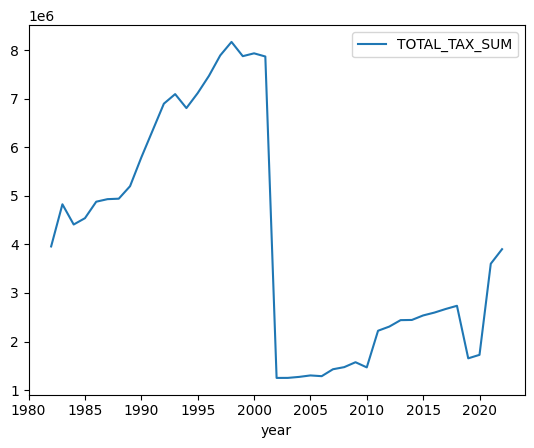

In [649]:
ambronay = df_filtered[df_filtered["mun_name"] == "AMBRONAY"]
ambronay["TOTAL_TAX_SUM"] = ambronay.iloc[:,9:].sum(axis=1)
ambronay.insert(0, "TOTAL_TAX_SUM", ambronay.pop("TOTAL_TAX_SUM"))
ambronay.plot(x="year", y="TOTAL_TAX_SUM")

That's a pretty big drop... I wonder if that's consistent between all the data?

In [650]:
g = ambronay.sort_values("year").drop(columns=["mun_name", "reg_name"]).iloc[18:23].T.apply(pd.to_numeric, errors='coerce')
g.loc[~(g==0).all(axis=1)]

832728     796054  \
TOTAL_TAX_SUM                                      7932746.00 7867500.00   
 INSEE code                                           1007.00    1007.00   
year                                                  2000.00    2001.00   
 REGION CODE                                            82.00      82.00   
pop                                                   2247.00    2247.00   
 ETF - COMMON / ACTUAL AMOUNT                       170344.00  171313.00   
FNB - CHAMBER OF AGRICULTURE / ACTUAL AMOUNT         56691.00   57004.00   
FB - MUNICIPALITY / ACTUAL AMOUNT                  1210509.00 1300889.00   
TH - MUNICIPALITY / ACTUAL AMOUNT INCLUDING THP...  903186.00  934048.00   
CFE - COMMON / REAL NET PRODUCT                    1549241.00 1398245.00   
CFE - INTERCOMMUNALITY / REAL NET PRODUCT / SIN...       0.00       0.00   
CFE - CHAMBER OF COMMERCE AND INDUSTRY / REAL N...   68468.00   62655.00   
 CFE - CHAMBER OF TRADE / ADDITIONAL DUTY / NET...    7934.00    9596.00   

                                                       759377     722701  \
TOTAL_TAX_SUM                                      1250486.00 1251184.00   
 INSEE code                                           1007.00    1007.00   
year                                                  2002.00    2003.00   
 REGION CODE                                            82.00       0.00   
pop                                                   2247.00    2247.00   
 ETF - COMMON / ACTUAL AMOUNT                        26242.00   27629.00   
FNB - CHAMBER OF AGRICULTURE / ACTUAL AMOUNT          8864.00    9580.00   
FB - MUNICIPALITY / ACTUAL AMOUNT                   205763.00  215136.00   
TH - MUNICIPALITY / ACTUAL AMOUNT INCLUDING THP...  148049.00  154446.00   
CFE - COMMON / REAL NET PRODUCT                     224259.00       0.00   
CFE - INTERCOMMUNALITY / REAL NET PRODUCT / SIN...       0.00  206366.00   
CFE - CHAMBER OF COMMERCE AND INDUSTRY / REAL N...   10282.00   10603.00   
 CFE - CHAMBER OF TRADE / ADDITIONAL DUTY / NET...    1784.00    1832.00   

                                                       686022  
TOTAL_TAX_SUM                                      1271646.00  
 INSEE code                                           1007.00  
year                                                  2004.00  
 REGION CODE                                             0.00  
pop                                                   2247.00  
 ETF - COMMON / ACTUAL AMOUNT                        29037.00  
FNB - CHAMBER OF AGRICULTURE / ACTUAL AMOUNT         10062.00  
FB - MUNICIPALITY / ACTUAL AMOUNT                   221188.00  
TH - MUNICIPALITY / ACTUAL AMOUNT INCLUDING THP...  163341.00  
CFE - COMMON / REAL NET PRODUCT                          0.00  
CFE - INTERCOMMUNALITY / REAL NET PRODUCT / SIN...  199655.00  
CFE - CHAMBER OF COMMERCE AND INDUSTRY / REAL N...   10591.00  
 CFE - CHAMBER OF TRADE / ADDITIONAL DUTY / NET...    1949.00

It's certainly the case with at least Ambronay, where we see a huge drop of tax revenue between 2001 and 2002. It turns out, all of the data in the dataset does this. This presents an interesting problem. There are several ways to interpret it, and several ways to deal with it.

### **Interpretation 1**
_The tax values we selected originally were incomplete and do not accurately represent the data_

This is the obvious consideration, and we can surmise that there's a missing tax somewhere that we forgot to include, which changed between 2001 and 2002. Perhaps the tax revenues from our other variables were funneled into this missing tax in 2002, or distributed in some other way we did not capture.

A quick and dirty way to figure if this is the case is to just plot the entire dataset's variables instead of the ones we hand-picked, and see if the same pattern emerges. If it does, we know it's not our fault. If it doesn't, we must go back and identify the missing variables.

With every column, data has shape: (10000, 252)


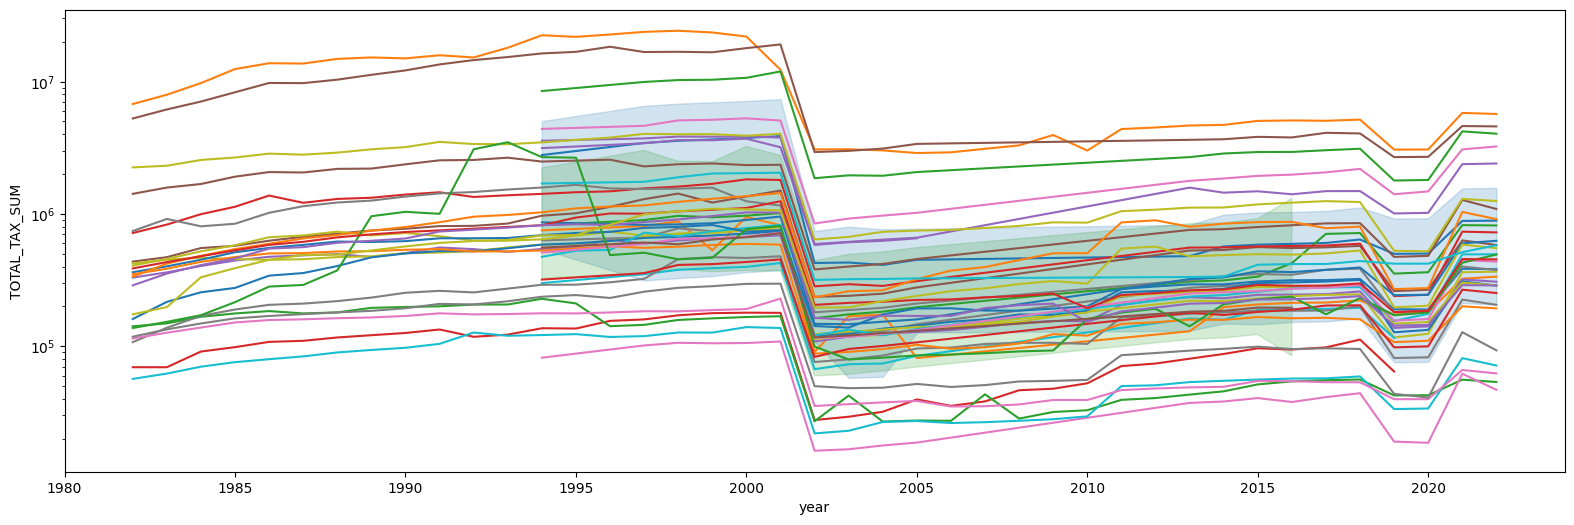

In [651]:
query = """
SELECT * from francetax WHERE (ANNEE = 2001 OR ANNEE = 2002) LIMIT 10000;
"""

%reset_selective -f data
try: del data
except: pass
data = client.query(query, print_query=False)
label = data.pop("Libellé commune")

# Clean, force every column as an integer, drop the columns that are all NaN
data = data.apply(pd.to_numeric, errors='coerce')
data = data.dropna(axis=1, how="all")
data.insert(0, "mun_name", label) # add the labels back

print("With every column, data has shape:", data.shape)
data["TOTAL_TAX_SUM"] = data.iloc[:,1:].sum(axis=1)
data.insert(0, "TOTAL_TAX_SUM", data.pop("TOTAL_TAX_SUM"))

# === Graph
sample_df = data.sample(40, random_state=11)
cities = sample_df["mun_name"].unique()

fig = plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(1,1, right=2)
ax = fig.add_subplot(gs[0,0])

for city in cities:
    city_df = df_filtered[df_filtered["mun_name"] == city]
    city_df["TOTAL_TAX_SUM"] = city_df.iloc[:,9:].sum(axis=1)
    city_df.insert(0, "TOTAL_TAX_SUM", city_df.pop("TOTAL_TAX_SUM"))
    #city_df.plot(x="year", y="TOTAL_TAX_SUM")
    g = sns.lineplot(data=city_df, ax=ax, x="year", y="TOTAL_TAX_SUM")
    g.set(yscale="log")

##### **Conclusion**
Even with adding literally every numeric variable, even the ones that aren't contextual, we see the same pattern. This means we didn't forget something and that's just how the data is. Perhaps this change is due to a historical issue with the French economy? Probably not though. France's GDP did take a small dip during this time (https://tradingeconomics.com/france/gdp), but not that much.

---
French GDP ~2001 - 2002 \
![im2.png](im2.png)

---

### **Interpretation 2**
_The data simply does not explain the dip in tax revenue_

This is actually not a bad thing for multiple reasons. Primarily because we are not trying to identify trends in the data, and we can still accurately measure municipality growth over time (with a hiccup in 2002), top and bottom earners, and other similar data. The dip seems to have affected everyone equally, and even if it didn't, there isn't anything we can do about it. The only issue we'll have is when feeding this into an ML model later - because ML tends to be of a predictive nature and requires continuous data, we'll use the last half (> 2002) of the data to train it, and ignore the first half. This isn't technically necessary, but will improve accuracy.

##### **Conclusion**
Do nothing! Hurray!

We could also normalize the drop and remove it completely by adding some static value to every piece of data after 2001, although since it looks like the data from today is roughly accurate when compared to the 2008 data from Ambronay, this new computed value would likely be inaccurate.

### **Interpretation 3**
_Something happened to the french fiscal / tax system in this time period that explains this drop_

One hypothesis is that this drop is a conversion rate issue. According to [this page](https://economy-finance.ec.europa.eu/euro/eu-countries-and-euro/france-and-euro_en) (economy-finance.ec.europa.eu), France adopted the Euro 1 Jan 2002, with a conversion rate of **€1 = 6.55957 FRF**.

If we use the data from Ambronay above, we can see that the ratios for conversion between the franc and the decrease in income approximately match:

\begin{gather*}
Euro\ :\ Franc\ Ratio\\
1 = 6.55957 FRF\\
\\
Ambronay\ Euro\ :\ Ambronay\ Franc\ Ratio\ 2001\ >\ 2002:\\
4926508 / 777836 = 6.334
\end{gather*}

So more than likely this large drop in data is probably caused by a currency issue. A 15.2% ratio and a 15.8% ratio are close enough, especially considering there was some income change in the province over that single year anyway. A small error is expected.

##### **Conclusion**
We can convert the Francs data to Euros and this bump should level out.

<Axes: xlabel='year'>

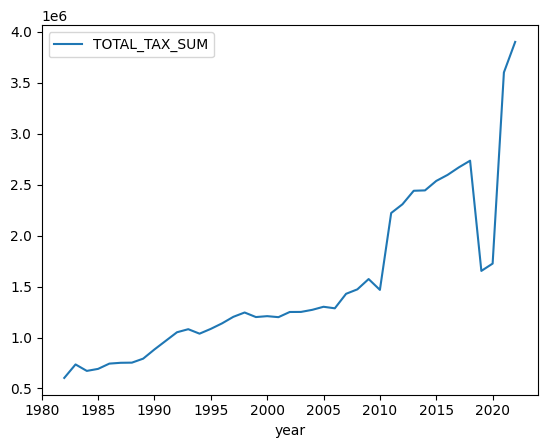

In [652]:
ambronay = df_filtered[df_filtered["mun_name"] == "AMBRONAY"]
ambronay["TOTAL_TAX_SUM"] = ambronay.iloc[:,9:].sum(axis=1)
ambronay.loc[ambronay['year'] < 2002, "TOTAL_TAX_SUM"] /= 6.557957
ambronay.plot(x="year", y="TOTAL_TAX_SUM")

Yay! This seems to have worked and made the data more regularly continuous. Let's do the same with the rest of the data.

In [653]:
df_filtered.head()

mun_name  INSEE code  year  REGION CODE dep_name  \
0  ABERGEMENT CLEMENCIAT       01001  2022           84      AIN   
1    ABERGEMENT DE VAREY       01002  2022           84      AIN   
2      AMBERIEU EN BUGEY       01004  2022           84      AIN   
3    AMBERIEUX EN DOMBES       01005  2022           84      AIN   
4                AMBLEON       01006  2022           84      AIN   

               reg_name   EPT SIREN NUMBER  NAME OF THE EPT      pop  \
0  AUVERGNE-RHONE-ALPES               0.00                0   798.00   
1  AUVERGNE-RHONE-ALPES               0.00                0   257.00   
2  AUVERGNE-RHONE-ALPES               0.00                0 14514.00   
3  AUVERGNE-RHONE-ALPES               0.00                0  1776.00   
4  AUVERGNE-RHONE-ALPES               0.00                0   118.00   

    ETF - COMMON / ACTUAL AMOUNT  ...  \
0                       28443.00  ...   
1                         788.00  ...   
2                       23997.00  ...   
3                       30661.00  ...   
4                        3001.00  ...   

   CFE - GEMAPI / REAL NET INTERCOMMUNAL PRODUCT / SINGLE FP  \
0                                             154.00           
1                                              26.00           
2                                           12060.00           
3                                             662.00           
4                                              42.00           

   CFE - GEMAPI / REAL NET INTERCOMMUNAL PRODUCT / FPZ IN ZAE  \
0                                               0.00            
1                                               0.00            
2                                               0.00            
3                                               0.00            
4                                               0.00            

   CFE - GEMAPI / REAL NET INTERCOMMUNAL PRODUCT / FPE IN WIND ZONE  \
0                                               0.00                  
1                                               0.00                  
2                                               0.00                  
3                                               0.00                  
4                                               0.00                  

   CFE - TASA / REAL NET PRODUCT  \
0                           0.00   
1                           0.00   
2                           0.00   
3                           0.00   
4                           0.00   

   CFE - CHAMBER OF COMMERCE AND INDUSTRY / REAL NET PRODUCT  \
0                                             139.00           
1                                              50.00           
2                                           57309.00           
3                                            1149.00           
4                                              52.00           

    CFE - CHAMBER OF TRADE / ADDITIONAL DUTY / NET PRODUCT  \
0                                             558.00         
1                                               0.00         
2                                           42773.00         
3                                            2639.00         
4                                               0.00         

    IFER TOTAL / MUNICIPALITY   IFER TOTAL / INTERCOMMUNALITY  \
0                        0.00                           71.00   
1                        0.00                            0.00   
2                        0.00                            0.00   
3                        0.00                            0.00   
4                        0.00                            0.00   

   DCRTP / Municipality  TOTAL_TAX_SUM  
0                  0.00      297082.00  
1                  0.00      116438.00  
2              39749.00    11291328.00  
3                  0.00      803026.00  
4                  0.00       55009.00  

[5 rows x 53 columns]

In [654]:
df_filtered.loc[df_filtered['year'] < 2002, "TOTAL_TAX_SUM"] /= 6.557957

### Additional Thoughts

**Aggregation** \

**INSEE Codes** \
Some of the INSEE codes are missing, or change over time. These codes change inconsistently based on local or federal laws, introduction of new communes or elimination of old ones, fiscal systems changing, and other reasons. As such they may be considered one unique identifier of a region, but instead we will just be going with names of communes, since any duplicated tax information between them will be in name only, and in theory communes of the same name will have different tax amounts, so there shouldn't be any problems.

**Municipality names** \
Some of the names are missing, 34 of the names are #NOM? which is just missing data. Most of the rest of the names are populated, although there are duplicates, because some regions share a name. This shouldn't be a problem, because in this dataset we are really only exploring the top and bottom of certain statistics (revenue, growth, etc) none of which share names.

**Importance of Margin of Error in this dataset** \
This dataset uses tax information for provinces that derive their income from local laws, federal and local offices, historical records, changes in populations and coding, certain tax breaks, union income, etc. We assume in this dataset that such inconsistencies between data are both infeasible to remediate at scale, and ultimately not important; for the most part we are identifying trends in the data applying errors, where they exist, to the entirety of the dataset. As such, if we select a wrong tax, or choose to apply a multiplicative value (like a conversion rate between Francs and Euros, for example), our outcome does not change. If we are choosing a tax to apply, we apply it to the whole dataset.

This may push some results slightly higher or lower on certain graphs (but probably not because each tax is relatively small compared to the total income of a region) which is also not important because our goal is to provide information for the top 5 and bottom 5 communes for various statistics, and in this report we often go up to 10 each instead of 5. Hypothetically if 5th place got bumped down to 6th because of an oversight or misunderstanding of the data, that commune is still represented / visualized because of our large allowance for such error in our graphing decisions.


## Second Look

We've seen the data visually, let's start analyzing it.

In [655]:
def summary_summary(df):

    def count_outliers(df):
        outliers = {}
        for col in df.select_dtypes(include=[np.number]).columns:
            outliers[col] = (df[col] > df[col].quantile(0.99)).sum()
        return pd.Series(outliers)

    summary = df.describe().T[["count", "mean", "std", "min", "max"]]

    s = pd.DataFrame({
        "unique": pd.Series([len(df[x].value_counts()) for x in df.columns], index=df.columns),
        "null": df.isnull().sum(),
        "dtypes": df.dtypes,
        "dupe": [df.duplicated().sum() for x in df.columns],
        "outliers": count_outliers(df)
    })
    s = pd.concat([s, summary], axis=1).fillna(" ")
    s["outliers"] = [int(x) if x != " " else " " for x in s["outliers"]]
    s["count"] = [int(x) if x != " " else " " for x in s["count"]]
    return s.sort_values("dtypes")

try:
    with open("summary_summary.csv", "r") as f:
        pass
    dis = pd.read_csv("summary_summary.csv", index_col=0)
except:
    dis = summary_summary(df_filtered)
    dis.to_csv("summary_summary.csv")

### Summary Statistics on each tax, and total tax

In [656]:

dis

unique  null   dtypes  \
year                                                    41     0    int64   
FB - MUNICIPALITY / ACTUAL AMOUNT                   488363     0  float64   
FB - O.M. REMOVAL TAX / FULL RATE - SMOOTH NET ...  298405     0  float64   
FB - TASA / ACTUAL AMOUNT                             7317     0  float64   
FB - TSE / ACTUAL AMOUNT                             37997     0  float64   
FB - TSE OTHERS / REAL NET AMOUNT                     8278     0  float64   
FB - UNION AND ORG. ASSIMILES / ACTUAL AMOUNT        61354     0  float64   
FNB - CAAA / PROPORTIONAL RIGHT - ACTUAL AMOUNT      35658     0  float64   
FNB - CHAMBER OF AGRICULTURE / ACTUAL AMOUNT        125673     0  float64   
FNB - TSE GRAND PARIS OR EPFL GUADELOUPE OR EPF...    1302     0  float64   
TH - COMMUNITY / REAL COMMUNAL AMOUNT OF THP/E ...   32298     0  float64   
TH - INTERCOMMUNALITY / ACTUAL AMOUNT OF WHICH ...  177302     0  float64   
TH - INTERCOMMUNALITY / ACTUAL INTERCOMMUNALITY...   24773     0  float64   
TH - INTERCOMMUNALITY / ACTUAL INTERCOMMUNALITY...   28096     0  float64   
TH - MUNICIPALITY / ACTUAL AMOUNT INCLUDING THP...  448624     0  float64   
TH - MUNICIPALITY / REAL COMMUNAL AMOUNT FOR TH...   29019     0  float64   
TH - REAL INTERCOMMUNAL AMOUNT GEMAPI TAX            14496     0  float64   
TH - TSE / ACTUAL AMOUNT                             34852     0  float64   
TH - TSE GRAND PARIS OR EPFL GUADELOUPE OR EPFL...    8276     0  float64   
TH - UNION AND ORG.ASSIMILES / ACTUAL AMOUNT         58721     0  float64   
TOTAL_TAX_SUM                                       802311     0  float64   
pop                                                  22262     0  float64   
FB - INCENTIVE TAX FOR REMOVAL OF HOUSEHOLD WAS...     169     0  float64   
FB - GFP / REAL AMOUNT                              132642     0  float64   
 CFE - CHAMBER OF TRADE / ADDITIONAL DUTY / NET...   57597     0  float64   
CFE - CHAMBER OF COMMERCE AND INDUSTRY / REAL N...  184662     0  float64   
 EPT SIREN NUMBER                                       12     0  float64   
 ETF - COMMON / ACTUAL AMOUNT                       272888     0  float64   
 ETF - GFP / ACTUAL AMOUNT                           59256     0  float64   
 FNB - GEMAPI / REAL INTER-COMMUNALITY AMOUNT         3761     0  float64   
 FNB - UNION AND SIMILAR ORGANIZATIONS / ACTUAL...   41169     0  float64   
 IFER TOTAL / INTERCOMMUNALITY                        8675     0  float64   
FB - GEMAPI / REAL INTER-COMMUNALITY AMOUNT          16409     0  float64   
CFE - GEMAPI / REAL INTERCOMMUNAL NET PRODUCT /...    9749     0  float64   
CFE - GEMAPI / REAL NET INTERCOMMUNAL PRODUCT /...    2111     0  float64   
FB - INCENTIVE TAX FOR REMOVAL OF HOUSEHOLD WAS...    5331     0  float64   
CFE - GEMAPI / REAL NET INTERCOMMUNAL PRODUCT /...     183     0  float64   
CFE - GEMAPI / REAL NET INTERCOMMUNAL PRODUCT /...    7996     0  float64   
CFE - INTERCOMMUNALITY / REAL NET PRODUCT / FPE...     716     0  float64   
CFE - INTERCOMMUNALITY / REAL NET PRODUCT / FPZ...     222     0  float64   
CFE - INTERCOMMUNALITY / REAL NET PRODUCT / SIN...   35371     0  float64   
CFE - INTERCOMMUNALITY / REAL NET PRODUCT / SIN...  166463     0  float64   
CFE - TASA / REAL NET PRODUCT                         5323     0  float64   
CFE - TSE / REAL NET PRODUCT                         46041     0  float64   
ETF - TSE / ACTUAL AMOUNT                             6422     0  float64   
CFE - GEMAPI / REAL NET INTERCOMMUNAL PRODUCT /...     118     0  float64   
 REGION CODE                                           109     0   object   
 NAME OF THE EPT                                        12     0   object   
 INSEE code                                          40070     0   object   
dep_name                                               105     0   object   
mun_name                                             52340     0   object   
reg_name                                        

### Top Municipalities by total tax, per year

Top earners is most relevant in two ways: This year (or most recent, 2022) and over time. We'll start with a quick and dirty top earners table and see it visualized.

In [657]:
df_top = df_filtered[df_filtered["year"] == 2022][["mun_name", "year", "reg_name", "pop", "TOTAL_TAX_SUM"]].sort_values("TOTAL_TAX_SUM", ascending=False)
df_top.head(10)

mun_name  year                    reg_name        pop  \
29262  VILLE DE PARIS  2022               ILE-DE-FRANCE 2182174.00   
4345        MARSEILLE  2022  PROVENCE-ALPES-COTE D'AZUR  877095.00   
11804        TOULOUSE  2022                   OCCITANIE  498596.00   
27098            LYON  2022        AUVERGNE-RHONE-ALPES  529570.00   
1956             NICE  2022  PROVENCE-ALPES-COTE D'AZUR  345528.00   
12365        BORDEAUX  2022          NOUVELLE-AQUITAINE  264257.00   
16305          NANTES  2022            PAYS DE LA LOIRE  323975.00   
13010     MONTPELLIER  2022                   OCCITANIE  298933.00   
26546      STRASBOURG  2022                   GRAND-EST  290106.00   
22138           LILLE  2022         LES-HAUTS-DE-FRANCE  236400.00   

       TOTAL_TAX_SUM  
29262  2115451734.00  
4345    814933029.00  
11804   670602183.00  
27098   608221968.00  
1956    472095847.00  
12365   367324321.00  
16305   359043977.00  
13010   340468998.00  
26546   293323171.00  
22138   251085753.00

Text(0.5, 1.0, 'Top Municipalities 2022')

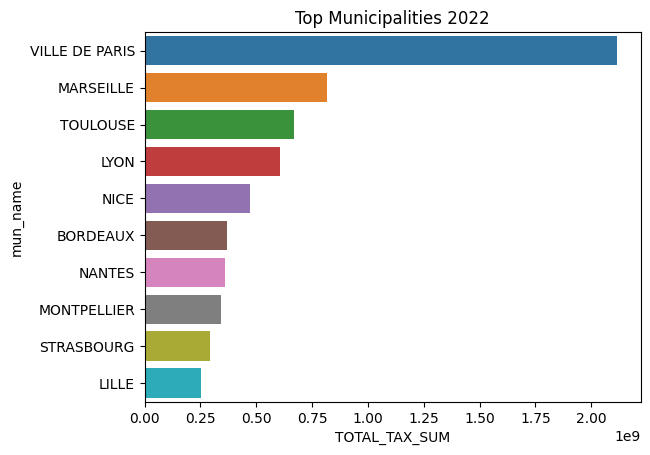

In [658]:
g = sns.barplot(df_top.head(10), y="mun_name", x="TOTAL_TAX_SUM", hue="mun_name");
g.set_title("Top Municipalities 2022")

Below we have two graphs. One is a time series of top earners, another is just a per-year measurement for the last 5 years.

In [659]:
# Set up top earners data
years = set()
regions = set()
for year in df_filtered["year"].unique():
    df_year = df_filtered[(df_filtered["year"] == year) & (df_filtered["TOTAL_TAX_SUM"] > 0)].sort_values("TOTAL_TAX_SUM")[["mun_name", "year", "TOTAL_TAX_SUM"]]
    top6 = df_year.tail(8)
    regions.update(top6["mun_name"])
    years.update(top6["year"])

# Gather all of the years and regions for top 8 regions and put them into an empty dataframe to load stuff into
df = pd.DataFrame(columns=list(regions), index=list(years))

# Load the data into each x,y location
for year in df_filtered["year"].unique():
    df_year = df_filtered[(df_filtered["year"] == year) & (df_filtered["TOTAL_TAX_SUM"] > 0)].sort_values("TOTAL_TAX_SUM")[["mun_name", "year", "TOTAL_TAX_SUM"]]
    top6 = df_year.tail(8)
    for reg,tax in zip(top6["mun_name"], top6["TOTAL_TAX_SUM"]):
        df.loc[year, reg] = int(tax)

# Create a list of dataframes covering last 5 years for top earners data
top5 = []
for year in range(2018, 2023):
    temp = df_filtered[(df_filtered["year"] == year) & (df_filtered["TOTAL_TAX_SUM"] > 0)].sort_values("TOTAL_TAX_SUM", ascending=False)[["mun_name", "year", "TOTAL_TAX_SUM"]]
    top5.append(temp.drop_duplicates())

df

TOULOUSE       PARIS VILLE DE PARIS  MARSEILLE  LE HAVRE       LYON  \
1982   88903653   846940568            NaN  186801865       NaN  100261923   
1983   98559269   916525814            NaN  201919165       NaN  110949435   
1984  124389629  1025612978            NaN  227423619       NaN  128493298   
1985  140045909  1084237228            NaN  254783225  76606380  141480016   
1986  161073730  1129278748            NaN  274223316  84618470  151387403   
1987  167186083  1064399514            NaN  275454789  80648541  150448061   
1988  186761153  1074652150            NaN  285421784  82155579  156689946   
1989  196961619  1036173338            NaN  293712768  83766796  163379724   
1990  214976157  1098916220            NaN  312255155       NaN  184917783   
1991  232490912  1126151580            NaN  323298036       NaN  197474403   
1992  247971467  1173513817            NaN  322665268       NaN  208539204   
1993  261180536  1305425775            NaN  188081166       NaN  223188841   
1994  274537156  1475901447            NaN  194821532       NaN        NaN   
1995  285178257  1544757981            NaN  200641220       NaN  240190278   
1996  298297244  1638286297            NaN  214497681       NaN  252049784   
1997  309400163  1712972576            NaN  220649492       NaN  264878533   
1998  314339854  1764661392            NaN  234715512       NaN  277233835   
1999  312840138  1716793977            NaN  239097873       NaN  275934104   
2000  315922499  1685907632            NaN  244238098       NaN  279134059   
2001  169054128  1679622783            NaN  248316049       NaN  280525171   
2002  321653606  1634181877            NaN  393370591       NaN  295180332   
2003  321640645  1564505696            NaN  402880838       NaN  366057705   
2004  332666720  1571661341            NaN  425808350       NaN  376725396   
2005  347915673  1568404211            NaN  482502299       NaN  382609397   
2006  370636964  1604227533            NaN  541566787       NaN  391988393   
2007  387455285  1664461200            NaN  553005656       NaN  401625973   
2008  400785188  1694729988            NaN  578759161       NaN  412177672   
2009  428106987  1892833227            NaN  617962779       NaN  444373098   
2010  311632417  1455489944            NaN  487605236       NaN  352236459   
2011  389267364  1597709960            NaN  622734574       NaN  414736944   
2012  403193278  1642173255            NaN  643113715       NaN  427950694   
2013  419172503  1686100451            NaN  666825717       NaN  442862608   
2014  429178681  1752811231            NaN  696710577       NaN  449865512   
2015  485022265  1805010044            NaN  743998333       NaN  586046005   
2016  515583880  1818296077            NaN  756866904       NaN  596275699   
2017  525730873  1837816552            NaN  765627300       NaN  605506843   
2018  534803798         NaN     1863884432  778366916       NaN  617037207   
2019  323454255         NaN     1513863799  354961241       NaN  376550083   
2020  328986478         NaN     1535355646  363604813       NaN  386147398   
2021  711442063         NaN     2392210299  858080334       NaN  677295567   
2022  670602183         NaN     2115451734  814933029       NaN  608221968   

     MONTPELLIER   BORDEAUX       NICE SAINT-ETIENNE      LILLE  GRENOBLE  \
1982         NaN        NaN   99712370      58581906        NaN  55778997   
1983         NaN   60932322  118176113      62144805        NaN       NaN   
1984         NaN   70609388  145044629           NaN        NaN  70838320   
1985         NaN   80248779  160644368           NaN        NaN       NaN   
1986         NaN   88284327  180179115           NaN        NaN       NaN   
1987         NaN   90552353  180841926           NaN        NaN       NaN   
1988         NaN   95693350  190430280           NaN        NaN       NaN   
1989         NaN  107434577  200120947           NaN        NaN       NaN   
1990    95957859  121447323  21061984

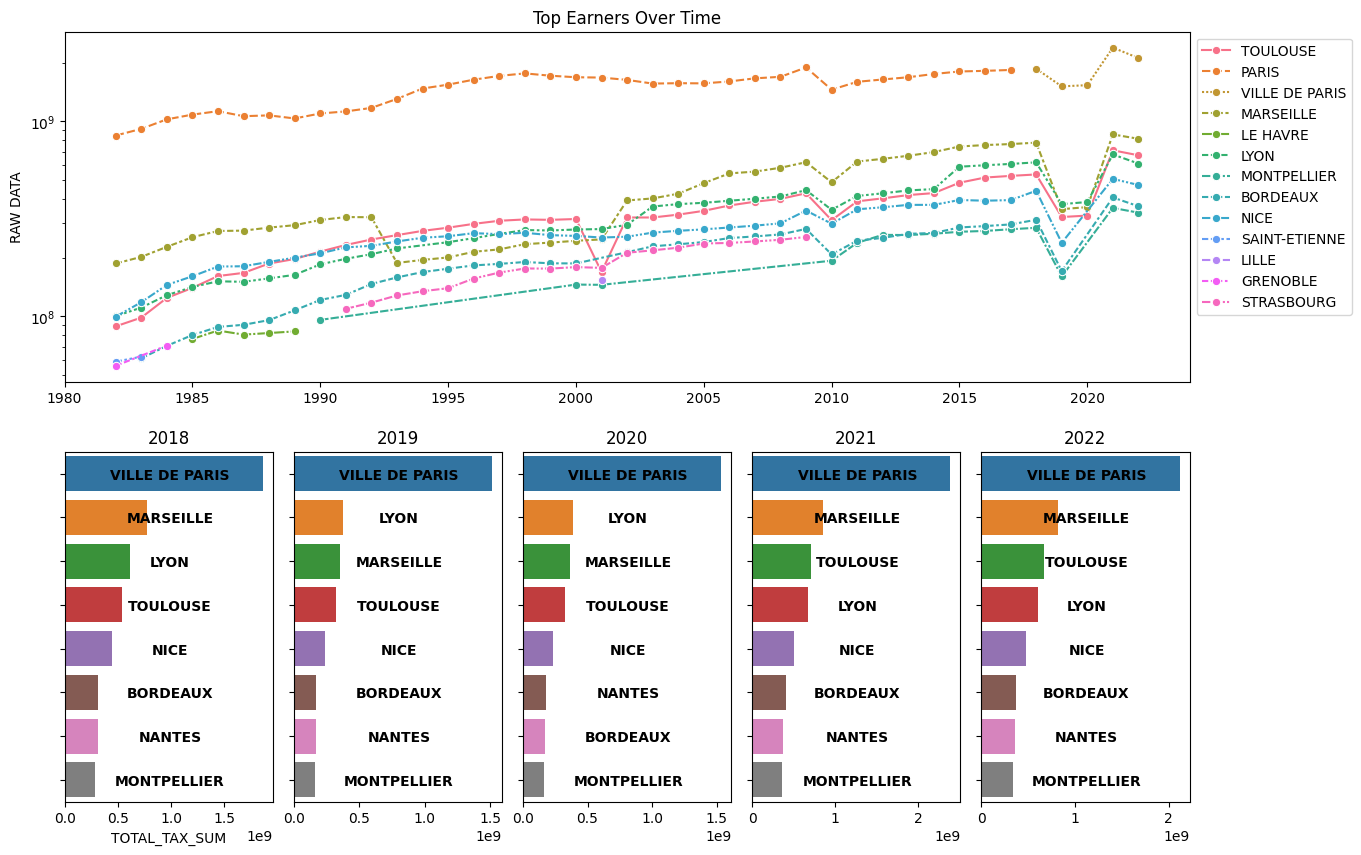

In [660]:
df_non_interp = df.drop(columns=["NANTES", "LYON *"])


# Graph the data
fig = plt.figure(figsize=(6,10))
gs = gridspec.GridSpec(2,5, right=2, hspace=0.2, wspace=0.1)
ax1 = fig.add_subplot(gs[0,:])
ax1.set_title("Top Earners Over Time")

g = sns.lineplot(df_non_interp, ax=ax1, marker='o', linestyle='')
g.set(yscale="log", ylabel="RAW DATA")
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))

for i, t in enumerate(top5):

    ax = fig.add_subplot(gs[1,i])
    j = sns.barplot(t.head(8), y="mun_name", x="TOTAL_TAX_SUM", hue="mun_name", ax=ax)
    j.set(title=t.iloc[0]["year"], ylabel="")
    j.set_yticklabels(j.get_yticklabels(), ha="center", fontdict={'weight': 'bold'})
    if i != 0:
        j.set(ylabel="", xlabel="")
    
    trans = mtrans.Affine2D().translate(115, 0)
    for t in j.get_yticklabels():
        t.set_transform(t.get_transform()+trans)
        


Log scale vs normal scale

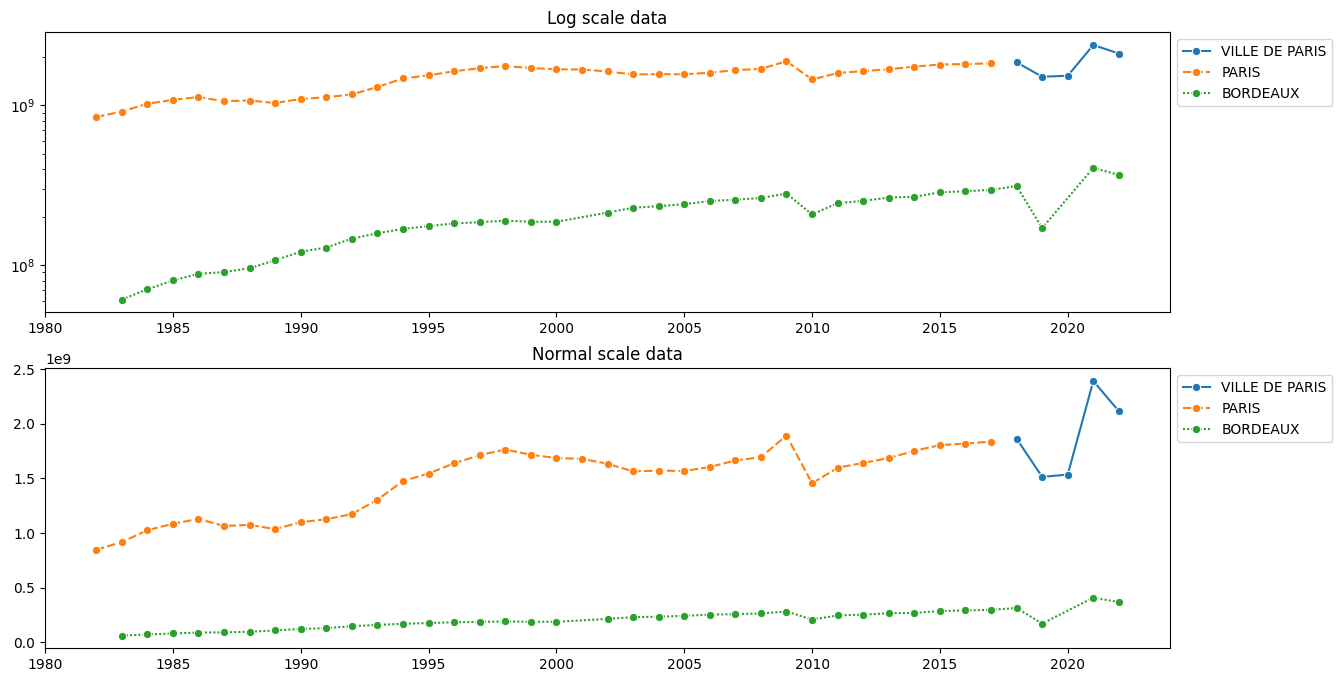

In [842]:
df_non_interp2 = df_non_interp[["VILLE DE PARIS", "PARIS", "BORDEAUX"]]

fig = plt.figure(figsize=(6,8))
gs = gridspec.GridSpec(2,1, right=2, hspace=0.2, wspace=0.1)
ax1 = fig.add_subplot(gs[0,0])
ax1.set_title("Log scale data")
ax2 = fig.add_subplot(gs[1,0])
ax2.set_title("Normal scale data")

g = sns.lineplot(df_non_interp2, ax=ax1, marker='o', linestyle='')
g.set(yscale="log")
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))


g = sns.lineplot(df_non_interp2, ax=ax2, marker='o', linestyle='')
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))

### Bottom Municipalities by total tax, per year

Bottom earners change so often that it's not worthwhile creating a time series graph of them. Instead, we can just provide a per-year table.

Quick and dirty summary of 2022's bottom earners:

In [662]:
df_bot = df_filtered[(df_filtered["year"] == 2022) & (df_filtered["TOTAL_TAX_SUM"] > 0)][["mun_name", "year", "reg_name", "pop", "TOTAL_TAX_SUM"]].sort_values("TOTAL_TAX_SUM", ascending=True)
df_bot.head(10)

mun_name  year                 reg_name    pop  \
34913               SAINT-ELIE  2022                   GUYANE 248.00   
9207                     RIOMS  2022     AUVERGNE-RHONE-ALPES  26.00   
10646               SORBOLLANO  2022                    CORSE  76.00   
8972                     AULAN  2022     AUVERGNE-RHONE-ALPES  13.00   
9098           IZON LA BRUISSE  2022     AUVERGNE-RHONE-ALPES  11.00   
3540         LA VILLE AUX BOIS  2022                GRAND-EST  27.00   
25840                     THUY  2022                OCCITANIE  17.00   
8496   CHATEAUVIEUX LES FOSSES  2022  BOURGOGNE-FRANCHE-COMTE  11.00   
9214             ROCHEFOURCHAT  2022     AUVERGNE-RHONE-ALPES   1.00   
8983        LA BATIE DES FONDS  2022     AUVERGNE-RHONE-ALPES   2.00   

       TOTAL_TAX_SUM  
34913         133.00  
9207          477.00  
10646         553.00  
8972          677.00  
9098          701.00  
3540          783.00  
25840         967.00  
8496         1165.00  
9214         1252.00  
8983         1381.00

Text(0.5, 1.0, 'Bottom Municipalities 2022')

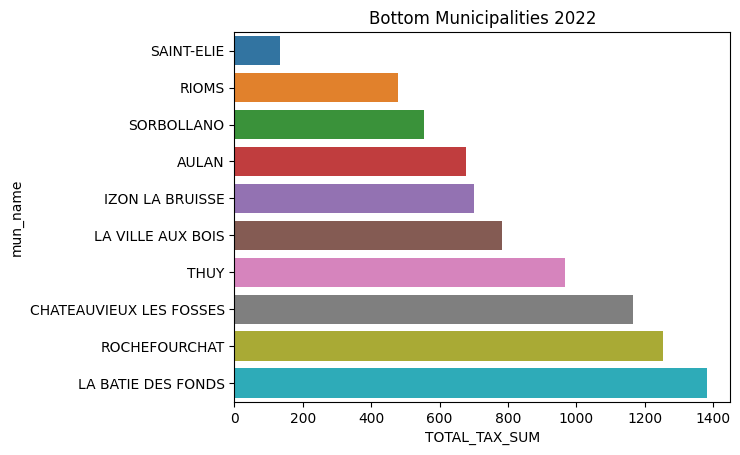

In [663]:
g = sns.barplot(df_bot.head(10), y="mun_name", x="TOTAL_TAX_SUM", hue="mun_name");
g.set_title("Bottom Municipalities 2022")

Below, we'll make a more thorough table of each represented year.

In [664]:
# Set up graphs of bottom 5
bot5 = []
for year in reversed(range(2013, 2023)):
    temp = df_filtered[(df_filtered["year"] == year) & (df_filtered["TOTAL_TAX_SUM"] > 0)].sort_values("TOTAL_TAX_SUM",)[["mun_name", "year", "TOTAL_TAX_SUM"]]
    bot5.append(temp.drop_duplicates())

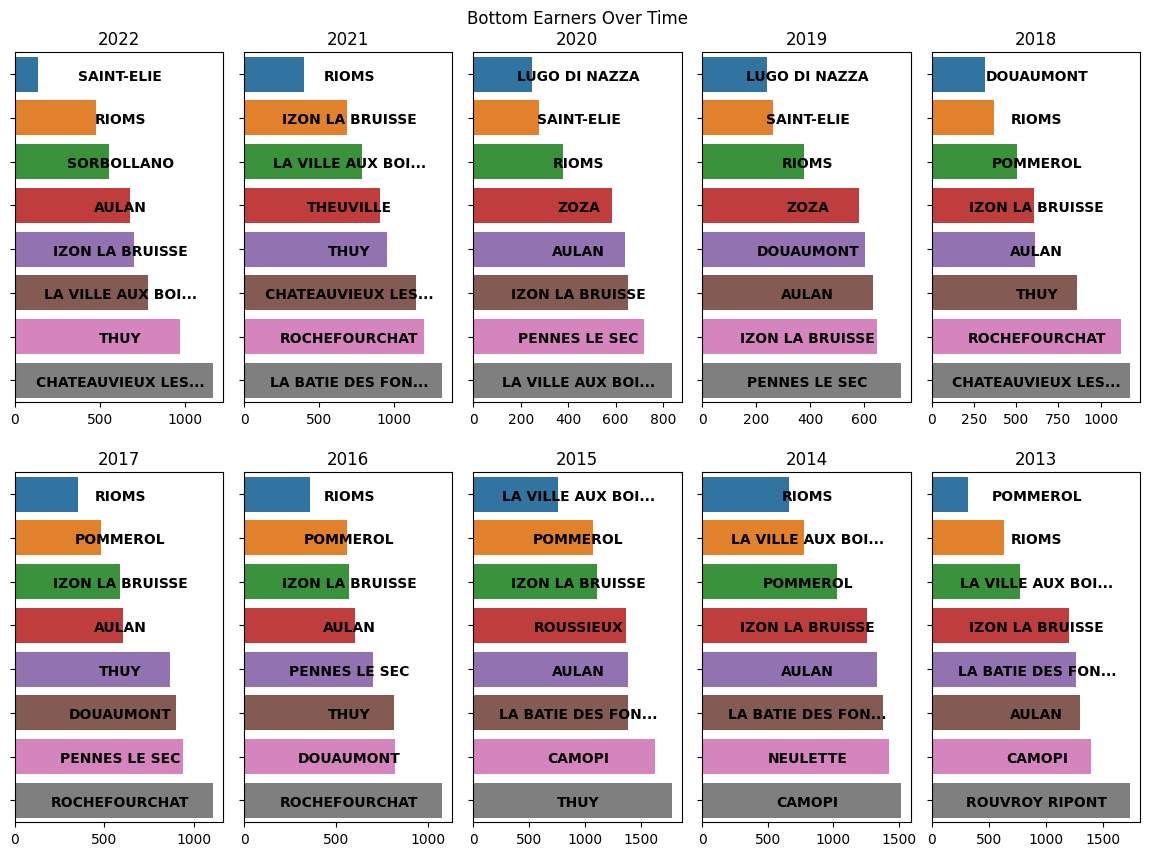

In [665]:
fig = plt.figure(figsize=(6,10))
gs = gridspec.GridSpec(2,5, right=2, hspace=0.2, wspace=0.1)
for x in range(2):
    for i in range(5):
        t = bot5[i + (x * 5)]
        ax = fig.add_subplot(gs[x,i%5])
        j = sns.barplot(t.head(8), y="mun_name", x="TOTAL_TAX_SUM", hue="mun_name", ax=ax)
        j.set(title=t.iloc[x*3 + i]["year"], ylabel="", xlabel="")
        j.set_yticklabels([  (x.get_text() if (len(x.get_text()) < 16) else x.get_text()[:16] + "...") for x in j.get_yticklabels()], ha="center", fontdict={'weight': 'bold'})
        if x == 0 and i == 2:
            j.set(title="Bottom Earners Over Time\n" + str(t.iloc[x*3 + i]["year"]))
        trans = mtrans.Affine2D().translate(115, 0)
        for t in j.get_yticklabels():
            t.set_transform(t.get_transform()+trans)
    

For a slightly more thorough understanding, I also provide a built-out set of tables for each year, in case someone wants more details.

In [666]:
def str_combiner(x, y):
    combined = ""
    for linex, liney in zip(iter(x.splitlines()), iter(y.splitlines())):
        combined += linex.strip() + " | " + liney.strip() + "\n"
    return combined

In [667]:
tables = []
for year in df_filtered["year"].unique():
    df_bot = df_filtered[( df_filtered["year"] == year) & (df_filtered["TOTAL_TAX_SUM"] > 0)][["mun_name", "TOTAL_TAX_SUM"]].sort_values("TOTAL_TAX_SUM").drop_duplicates().head(10)
    table = "=" * 35 + "\n"
    table += "|{:^33}|\n".format(year)
    
    for reg, num in zip(df_bot["mun_name"], df_bot["TOTAL_TAX_SUM"]):
        s = "|{:25}{:8.0f}|\n".format(
            reg, num
        )
        table += s
    
    tables.append(table)
def rec_print(tabs, rounds=2):
    if rounds > 0:
        for i in range( int(len(tabs) / 2)):
            t1 = tabs.pop(0)
            t2 = tabs.pop(0)
            tabs.append( str_combiner(t1,t2) )
        rec_print(tabs, rounds -1)
    else:
        for t in tabs:
            print(t)
        return

rec_print(tables[:-1])

=================================== | =================================== | =================================== | ===================================
|              2022               | | |              2021               | | |              2020               | | |              2019               |
|SAINT-ELIE                    133| | |RIOMS                         399| | |LUGO DI NAZZA                 246| | |LUGO DI NAZZA                 241|
|RIOMS                         477| | |IZON LA BRUISSE               683| | |SAINT-ELIE                    277| | |SAINT-ELIE                    262|
|SORBOLLANO                    553| | |LA VILLE AUX BOIS             784| | |RIOMS                         377| | |RIOMS                         375|
|AULAN                         677| | |THEUVILLE                     906| | |ZOZA                          583| | |ZOZA                          580|
|IZON LA BRUISSE               701| | |THUY                          955| | |AULAN                  

### Top Growers

We can categorize top growers in chunks of 5, 10, 15, and 20 years.

Because the huge dip in revenue around 2001 exists, this growth data is really only relevant from before and after that period. Luckily, 20 years from 2022 is 2002, which is right on the edge of being affected by that data anomaly. Just to be safe, we're going to remove that outlier data outright.

In [668]:


df_grow = df_filtered[["mun_name", "year", "TOTAL_TAX_SUM"]].drop_duplicates()
df_grow_gb = df_grow.groupby(["mun_name", "year"]).sum().reset_index()

# Remove dates before 2002
df_grow_gb = df_grow_gb[df_grow_gb["year"] > 2001]
df

TOULOUSE       PARIS VILLE DE PARIS  MARSEILLE  LE HAVRE       LYON  \
1982   88903653   846940568            NaN  186801865       NaN  100261923   
1983   98559269   916525814            NaN  201919165       NaN  110949435   
1984  124389629  1025612978            NaN  227423619       NaN  128493298   
1985  140045909  1084237228            NaN  254783225  76606380  141480016   
1986  161073730  1129278748            NaN  274223316  84618470  151387403   
1987  167186083  1064399514            NaN  275454789  80648541  150448061   
1988  186761153  1074652150            NaN  285421784  82155579  156689946   
1989  196961619  1036173338            NaN  293712768  83766796  163379724   
1990  214976157  1098916220            NaN  312255155       NaN  184917783   
1991  232490912  1126151580            NaN  323298036       NaN  197474403   
1992  247971467  1173513817            NaN  322665268       NaN  208539204   
1993  261180536  1305425775            NaN  188081166       NaN  223188841   
1994  274537156  1475901447            NaN  194821532       NaN        NaN   
1995  285178257  1544757981            NaN  200641220       NaN  240190278   
1996  298297244  1638286297            NaN  214497681       NaN  252049784   
1997  309400163  1712972576            NaN  220649492       NaN  264878533   
1998  314339854  1764661392            NaN  234715512       NaN  277233835   
1999  312840138  1716793977            NaN  239097873       NaN  275934104   
2000  315922499  1685907632            NaN  244238098       NaN  279134059   
2001  169054128  1679622783            NaN  248316049       NaN  280525171   
2002  321653606  1634181877            NaN  393370591       NaN  295180332   
2003  321640645  1564505696            NaN  402880838       NaN  366057705   
2004  332666720  1571661341            NaN  425808350       NaN  376725396   
2005  347915673  1568404211            NaN  482502299       NaN  382609397   
2006  370636964  1604227533            NaN  541566787       NaN  391988393   
2007  387455285  1664461200            NaN  553005656       NaN  401625973   
2008  400785188  1694729988            NaN  578759161       NaN  412177672   
2009  428106987  1892833227            NaN  617962779       NaN  444373098   
2010  311632417  1455489944            NaN  487605236       NaN  352236459   
2011  389267364  1597709960            NaN  622734574       NaN  414736944   
2012  403193278  1642173255            NaN  643113715       NaN  427950694   
2013  419172503  1686100451            NaN  666825717       NaN  442862608   
2014  429178681  1752811231            NaN  696710577       NaN  449865512   
2015  485022265  1805010044            NaN  743998333       NaN  586046005   
2016  515583880  1818296077            NaN  756866904       NaN  596275699   
2017  525730873  1837816552            NaN  765627300       NaN  605506843   
2018  534803798         NaN     1863884432  778366916       NaN  617037207   
2019  323454255         NaN     1513863799  354961241       NaN  376550083   
2020  328986478         NaN     1535355646  363604813       NaN  386147398   
2021  711442063         NaN     2392210299  858080334       NaN  677295567   
2022  670602183         NaN     2115451734  814933029       NaN  608221968   

     MONTPELLIER   BORDEAUX       NICE SAINT-ETIENNE      LILLE  GRENOBLE  \
1982         NaN        NaN   99712370      58581906        NaN  55778997   
1983         NaN   60932322  118176113      62144805        NaN       NaN   
1984         NaN   70609388  145044629           NaN        NaN  70838320   
1985         NaN   80248779  160644368           NaN        NaN       NaN   
1986         NaN   88284327  180179115           NaN        NaN       NaN   
1987         NaN   90552353  180841926           NaN        NaN       NaN   
1988         NaN   95693350  190430280           NaN        NaN       NaN   
1989         NaN  107434577  200120947           NaN        NaN       NaN   
1990    95957859  121447323  21061984

In [669]:
df_grow_gb

mun_name  year  TOTAL_TAX_SUM
0                         #NOM?  2011    22797862.00
1              - ANSE- BERTRAND  2002     1308994.00
2              - ANSE- BERTRAND  2003     1360117.00
4                - BAIE MAHAULT  2002    27307521.00
5                - BAIE MAHAULT  2003    27456929.00
...                         ...   ...            ...
1394736  lA CHAPELLE SOUS BRANC  2018      101002.00
1394737  lA CHAPELLE SOUS BRANC  2019       49872.00
1394738  lA CHAPELLE SOUS BRANC  2020       50895.00
1394739  lA CHAPELLE SOUS BRANC  2021      164688.00
1394740  lA CHAPELLE SOUS BRANC  2022      162443.00

[710691 rows x 3 columns]

In [670]:
# d = {
#     "mun_name":[],
#     "year":[],
#     "TOTAL_TAX_SUM":[],
#     "pct_change":[]
# }
# current_name = ""
# for row in df_grow_gb.iterrows():
#     d["mun_name"].append(row[1]["mun_name"])
#     d["year"].append(row[1]["year"])
#     d["TOTAL_TAX_SUM"].append(row[1]["TOTAL_TAX_SUM"])

#     if row[1]["mun_name"] == current_name:
#         # We are evaluating the same category, so can calculate pct_change from the previous cell
#         if d["TOTAL_TAX_SUM"][-2] > 0:
#             # If the previous was 0, ignore
#             diff = row[1]["TOTAL_TAX_SUM"] - d["TOTAL_TAX_SUM"][-2]
#             rate = diff / d["TOTAL_TAX_SUM"][-2]
#             d["pct_change"].append( rate * 100 )
#         else:
#             d["pct_change"].append(0.0)
#     else:
#         # We are evaluating a new name, so pct_change is 0 to initialize
#         d["pct_change"].append(0.0)
#         current_name = row[1]["mun_name"]

# df_grow_gb["pct_change"] = d["pct_change"]

In [671]:
# df_grow_gb[df_grow_gb["mun_name"] == "ABERGEMENT CLEMENCIAT"].head(25)
# df_grow_gb[df_grow_gb["mun_name"] == "ABERGEMENT CLEMENCIAT"][["pct_change"]].head(25).style.background_gradient(cmap='RdYlGn', high=-0.58)

In [672]:
# Loops are for the weak of mind

df_grow_gb_5 = df_grow_gb[df_grow_gb["year"] >= 2017].groupby("mun_name").apply(lambda x: x.iloc[[0, -1]]).reset_index(drop=True)
df_grow_gb_5["5yr_growth"] = 0.0
for i in range(1, df_grow_gb_5.shape[0], 2):
    df_grow_gb_5["5yr_growth"].iloc[i] = (df_grow_gb_5["TOTAL_TAX_SUM"].iloc[i] - df_grow_gb_5["TOTAL_TAX_SUM"].iloc[i-1]) / df_grow_gb_5["TOTAL_TAX_SUM"].iloc[i-1] * 100

df_grow_gb_10 = df_grow_gb[df_grow_gb["year"] >= 2012].groupby("mun_name").apply(lambda x: x.iloc[[0, -1]]).reset_index(drop=True)
df_grow_gb_10["10yr_growth"] = 0.0
for i in range(1, df_grow_gb_10.shape[0], 2):
    df_grow_gb_10["10yr_growth"].iloc[i] = (df_grow_gb_10["TOTAL_TAX_SUM"].iloc[i] - df_grow_gb_10["TOTAL_TAX_SUM"].iloc[i-1]) / df_grow_gb_10["TOTAL_TAX_SUM"].iloc[i-1] * 100

df_grow_gb_15 = df_grow_gb[df_grow_gb["year"] >= 2007].groupby("mun_name").apply(lambda x: x.iloc[[0, -1]]).reset_index(drop=True)
df_grow_gb_15["15yr_growth"] = 0.0
for i in range(1, df_grow_gb_15.shape[0], 2):
    df_grow_gb_15["15yr_growth"].iloc[i] = (df_grow_gb_15["TOTAL_TAX_SUM"].iloc[i] - df_grow_gb_15["TOTAL_TAX_SUM"].iloc[i-1]) / df_grow_gb_15["TOTAL_TAX_SUM"].iloc[i-1] * 100

df_grow_gb_20 = df_grow_gb[df_grow_gb["year"] >= 2002].groupby("mun_name").apply(lambda x: x.iloc[[0, -1]]).reset_index(drop=True)
df_grow_gb_20["20yr_growth"] = 0.0
for i in range(1, df_grow_gb_20.shape[0], 2):
    df_grow_gb_20["20yr_growth"].iloc[i] = (df_grow_gb_20["TOTAL_TAX_SUM"].iloc[i] - df_grow_gb_20["TOTAL_TAX_SUM"].iloc[i-1]) / df_grow_gb_20["TOTAL_TAX_SUM"].iloc[i-1] * 100

In [673]:

a = df_grow_gb_5.sort_values("TOTAL_TAX_SUM", ascending=False)[df_grow_gb_5["5yr_growth"] != 0]
b = df_grow_gb_10.sort_values("TOTAL_TAX_SUM", ascending=False)[df_grow_gb_10["10yr_growth"] != 0]
c = df_grow_gb_15.sort_values("TOTAL_TAX_SUM", ascending=False)[df_grow_gb_15["15yr_growth"] != 0]
dd = df_grow_gb_20.sort_values("TOTAL_TAX_SUM", ascending=False)[df_grow_gb_20["20yr_growth"] != 0]


In [674]:
paris = [df_grow_gb_5.loc[65625], df_grow_gb_10.loc[58331], df_grow_gb_15.loc[58559], df_grow_gb_20.loc[58913]]
paris = pd.DataFrame(paris)
paris.loc[65625, "mun_name"] = "PARIS"
paris

mun_name  year  TOTAL_TAX_SUM  5yr_growth  10yr_growth  15yr_growth  \
65625    PARIS  2022  2115451734.00       13.50          NaN          NaN   
58331    PARIS  2017  1837816552.00         NaN        11.91          NaN   
58559    PARIS  2017  1837816552.00         NaN          NaN        10.42   
58913    PARIS  2017  1837816552.00         NaN          NaN          NaN   

       20yr_growth  
65625          NaN  
58331          NaN  
58559          NaN  
58913        12.46

#### Top Growth by Highest Income Communes

Text(0.5, 1.0, 'Top Growth, Highest Grossing Municipalities')

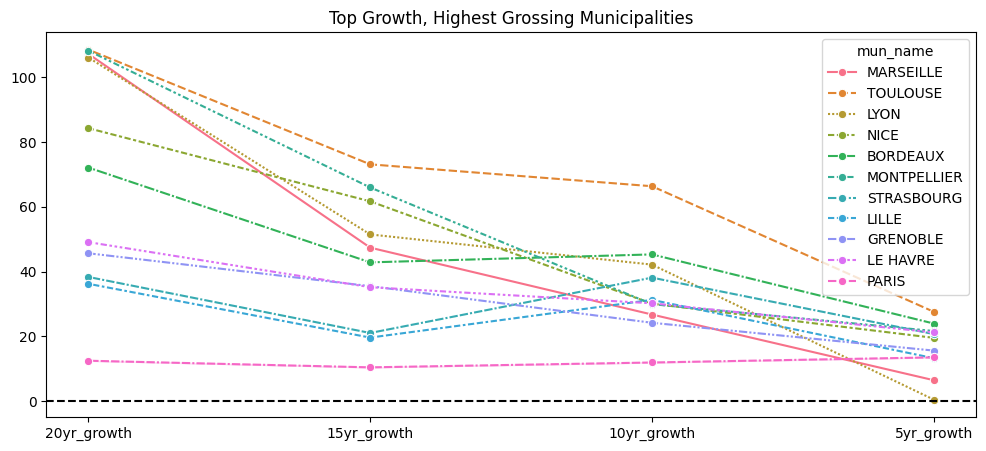

In [675]:
plt.figure(figsize=(12,5))
total_growth = a.merge(b, how="left")
total_growth = total_growth.merge(c, how="left")
total_growth = total_growth.merge(dd, how="left")
t = total_growth[total_growth["mun_name"].isin(df_non_interp.columns.tolist())][["mun_name","5yr_growth", "10yr_growth", "15yr_growth", "20yr_growth"]]
t = pd.concat([t, pd.DataFrame(paris)[["mun_name","5yr_growth", "10yr_growth", "15yr_growth", "20yr_growth"]]])
t = t[t["mun_name"] != "VILLE DE PARIS"]
cols = t.pop("mun_name")
t = t.T
t.columns = cols
g = sns.lineplot(t, marker='o', linestyle='')
g.invert_xaxis()
g.axhline(0, ls="--", color="k")
g.set_title("Top Growth, Highest Grossing Municipalities")

Most recent 5Y Growth

#### Top Growth over 5,10,15,20y by Highest Income Communes

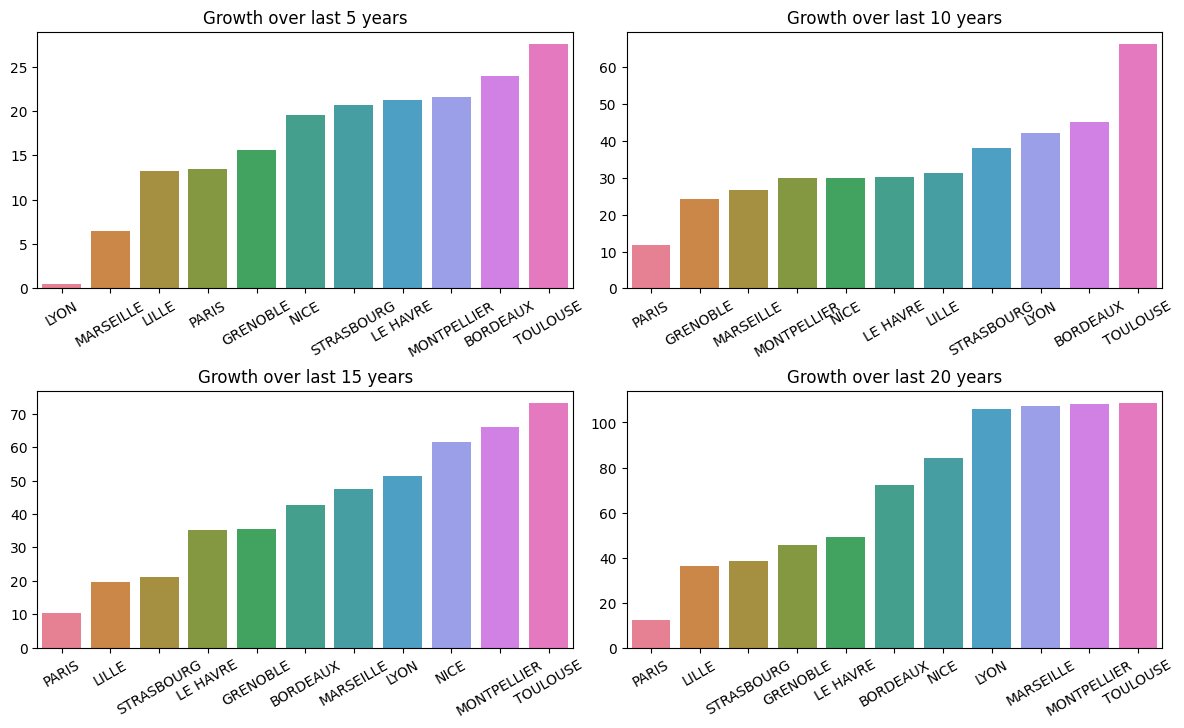

In [676]:
fig = plt.figure(figsize=(6,8))
gs = gridspec.GridSpec(2,2, right=2, hspace=0.4, wspace=0.1)
# ax0 = fig.add_subplot(gs[0,:])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
axs = [ax1,ax2,ax3,ax4]

for idx, i in enumerate(["5yr", "10yr", "15yr", "20yr"]):

    g = sns.barplot(t.T.sort_values("{}_growth".format(i)).T.iloc[[idx]], ax=axs[idx])
    g.set_xticklabels(g.get_xticklabels(), rotation=30);
    g.set_xlabel(None)
    g.set_title("Growth over last {} years".format(i[:-2]))


The previous graph shows growth of the top grossing states, the following shows top growth total

#### Top Growth For All Communes

In [748]:
t.T.head(10).sort_values("5yr_growth").T

mun_name     BRESSE VALLONS  ABIDOS  CHAMOLE  SURJOUX-LHOPITAL  \
5yr_growth          1009.77 1018.33  1095.71           1233.27   
10yr_growth         1009.77   60.11  1256.16           1233.27   
15yr_growth         1009.77  263.19  1811.49           1233.27   
20yr_growth         1009.77   62.30  1954.69           1233.27   

mun_name     CADEILHAN TRACHERE  LES MAZURES  EPIAIS LES LOUVRES  SINNAMARY  \
5yr_growth              1488.20      1734.93             1737.30    3293.28   
10yr_growth              757.77      1552.23             1566.58    4431.19   
15yr_growth              757.77        67.46             1566.58   14446.09   
20yr_growth              419.71      1410.56              283.74    1296.76   

mun_name     ILE MOLENE  ILE DE SEIN  
5yr_growth          inf          inf  
10yr_growth         inf          inf  
15yr_growth         inf          inf  
20yr_growth         inf          inf

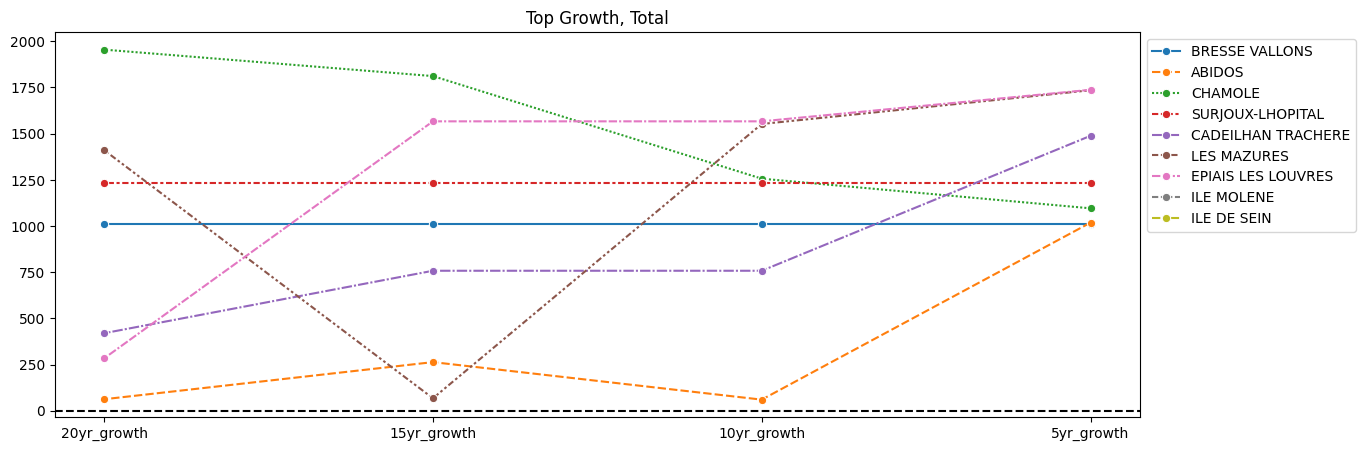

In [755]:
plt.figure(figsize=(14,5))
t = total_growth[["mun_name","5yr_growth", "10yr_growth", "15yr_growth", "20yr_growth"]]
t = pd.concat([t.sort_values("5yr_growth", ascending=False), pd.DataFrame(paris)[["mun_name","5yr_growth", "10yr_growth", "15yr_growth", "20yr_growth"]]])
t
t = t[t["mun_name"] != "VILLE DE PARIS"]
cols = t.pop("mun_name")
t = t.T
t.columns = cols

g = sns.lineplot(t.T.head(10).sort_values("5yr_growth").T.drop(columns=["SINNAMARY"]), marker='o', linestyle='')
g.invert_xaxis()
g.axhline(0, ls="--", color="k")
g.set_title("Top Growth, Total")
g.legend(bbox_to_anchor=(1,1), fontsize=10)

#### Top Growth Last 5y

In [768]:
t.T.sort_values("5yr_growth", ascending=False).head(12).tail(10)[["5yr_growth"]].T

mun_name    SINNAMARY  EPIAIS LES LOUVRES  LES MAZURES  CADEILHAN TRACHERE  \
5yr_growth    3293.28             1737.30      1734.93             1488.20   

mun_name    SURJOUX-LHOPITAL  CHAMOLE  ABIDOS  BRESSE VALLONS  \
5yr_growth           1233.27  1095.71 1018.33         1009.77   

mun_name    SAINT-HYMETIERE-SUR-VALOUSE  GOUFFERN EN AUGE  
5yr_growth                      1003.36            969.88

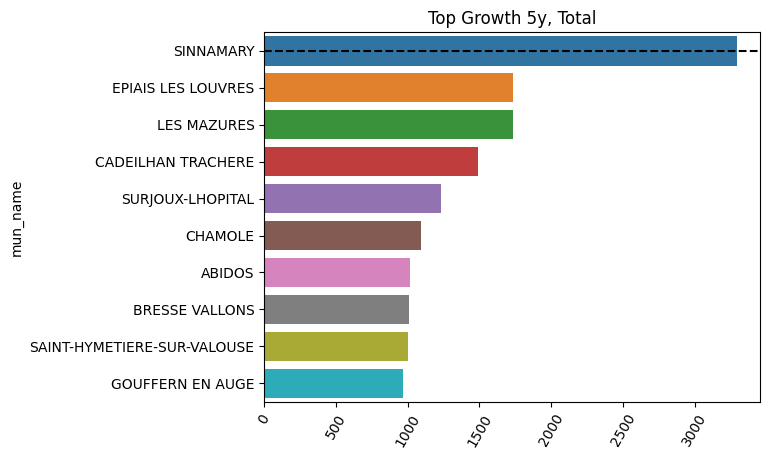

In [774]:
g = sns.barplot(t.T.sort_values("5yr_growth", ascending=False).head(12).tail(10)[["5yr_growth"]].T, orient="h")
# g.invert_xaxis()
g.axhline(0, ls="--", color="k")
g.set_title("Top Growth 5y, Total")
g.set_xticklabels(g.get_xticklabels(), rotation=60);
g.set_xlabel(None);

#### Lowest Growth For All Communes

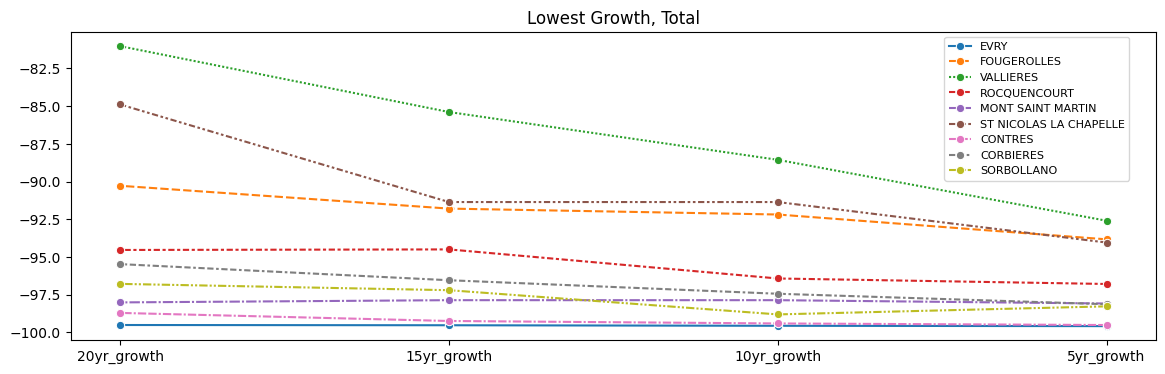

In [806]:
plt.figure(figsize=(14,4))
t = total_growth[total_growth["mun_name"].isin( total_growth.sort_values("5yr_growth")["mun_name"].head(10).to_list() )][["mun_name","5yr_growth", "10yr_growth", "15yr_growth", "20yr_growth"]]
cols = t.pop("mun_name")
t = t.T
t.columns = cols
t
g = sns.lineplot(t.drop(columns=["SAINT-ELIE"]), marker='o', linestyle='')
g.invert_xaxis()
g.legend(bbox_to_anchor=(0.8,0.5), fontsize=8)
g.set_title("Lowest Growth, Total");

In [821]:
df_filtered[df_filtered["mun_name"] == "FOUGEROLLES"][["mun_name", "year", "TOTAL_TAX_SUM"]][df_filtered["year"] > 2008].groupby("mun_name").apply(lambda x: x.iloc[[0, -1]]).reset_index(drop=True)

mun_name  year  TOTAL_TAX_SUM
0  FOUGEROLLES  2022      114999.00
1  FOUGEROLLES  2009     1422564.00

In [815]:
# Loops are for the weak of mind

df_grow_gb_5 = df_grow_gb[df_grow_gb["year"] >= 2017].groupby("mun_name").apply(lambda x: x.iloc[[0, -1]]).reset_index(drop=True)
df_grow_gb_5["5yr_growth"] = 0.0
for i in range(1, df_grow_gb_5.shape[0], 2):
    df_grow_gb_5["5yr_growth"].iloc[i] = (df_grow_gb_5["TOTAL_TAX_SUM"].iloc[i] - df_grow_gb_5["TOTAL_TAX_SUM"].iloc[i-1]) / df_grow_gb_5["TOTAL_TAX_SUM"].iloc[i-1] * 100

df_grow_gb_5

KeyError: 'TOTAL_TAX_SUM'

In [680]:
total_growth.to_csv("total_growth.csv")

In [681]:
total_growth

mun_name  year  TOTAL_TAX_SUM  5yr_growth  10yr_growth  \
0                VILLE DE PARIS  2022  2115451734.00       13.50        13.50   
1                     MARSEILLE  2022   814933029.00        6.44        26.72   
2                      TOULOUSE  2022   670602183.00       27.56        66.32   
3                          LYON  2022   608221968.00        0.45        42.12   
4                          NICE  2022   472095847.00       19.52        30.07   
...                         ...   ...            ...         ...          ...   
33686     BEAUMONT EN VERDUNOIS  2022           0.00         NaN          NaN   
33687   FLEURY DEVANT DOUAUMONT  2022           0.00         NaN          NaN   
33688    HAUMONT PRES SAMOGNEUX  2022           0.00         NaN          NaN   
33689    CUMIERES LE MORT HOMME  2022           0.00         NaN      -100.00   
33690  LOUVEMONT COTE DU POIVRE  2022           0.00         NaN          NaN   

       15yr_growth  20yr_growth  
0            13.50        13.50  
1            47.36       107.17  
2            73.08       108.49  
3            51.44       106.05  
4            61.66        84.24  
...            ...          ...  
33686          NaN      -100.00  
33687          NaN      -100.00  
33688          NaN      -100.00  
33689      -100.00      -100.00  
33690          NaN      -100.00  

[33691 rows x 7 columns]

### Correlations

Analyze the correlation between population size and tax revenue in municipalities (the variable for number of inhabitants in the dataset is Z08).

#### Corr() value and data visual

In [682]:
df_corr = df_filtered[["mun_name", "pop", "TOTAL_TAX_SUM"]].set_index("mun_name")
df_corr = df_corr[df_corr["pop"] > 10]
df_corr = df_corr[df_corr["TOTAL_TAX_SUM"] > 10].drop_duplicates()
df_corr.corr()

pop  TOTAL_TAX_SUM
pop           1.00           0.97
TOTAL_TAX_SUM 0.97           1.00

Correlation of this data is 0.97, which is almost perfect - let's take a look at some of this data graphed.

<Axes: xlabel='TOTAL_TAX_SUM', ylabel='pop'>

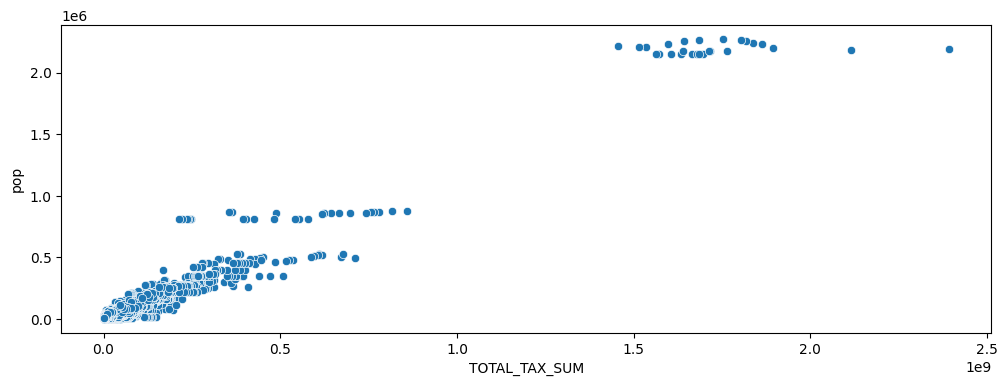

In [683]:
plt.figure(figsize=(12,4))
sns.scatterplot(df_corr, y="pop", x="TOTAL_TAX_SUM")

In [829]:
df_corr[(df_corr["pop"] > 650000) & (df_corr["pop"] < 1500000)]

pop  TOTAL_TAX_SUM
mun_name                          
MARSEILLE 877095.00   814933029.00
MARSEILLE 874619.00   858080334.00
MARSEILLE 869815.00   363604813.00
MARSEILLE 870018.00   354961241.00
MARSEILLE 869815.00   778366916.00
MARSEILLE 866644.00   765627300.00
MARSEILLE 864323.00   756866904.00
MARSEILLE 861676.00   743998333.00
MARSEILLE 859367.00   696710577.00
MARSEILLE 859368.00   666825717.00
MARSEILLE 858902.00   643113715.00
MARSEILLE 859543.00   622734574.00
MARSEILLE 860363.00   487605236.00
MARSEILLE 847084.00   617962779.00
MARSEILLE 807071.00   578759161.00
MARSEILLE 807071.00   553005656.00
MARSEILLE 807071.00   541566787.00
MARSEILLE 807071.00   482502299.00
MARSEILLE 807071.00   425808350.00
MARSEILLE 807071.00   402880838.00
MARSEILLE 807071.00   393370591.00
MARSEILLE 807071.00   248316049.80
MARSEILLE 807071.00   244238098.54
MARSEILLE 807726.00   239097873.62
MARSEILLE 807726.00   234715512.62
MARSEILLE 807726.00   220649492.06
MARSEILLE 807726.00   214497681.82

In [830]:
df_corr[(df_corr["TOTAL_TAX_SUM"] > 1000000000)]

pop  TOTAL_TAX_SUM
mun_name                                
VILLE DE PARIS 2182174.00  2115451734.00
VILLE DE PARIS 2192485.00  2392210299.00
VILLE DE PARIS 2204773.00  1535355646.00
VILLE DE PARIS 2210875.00  1513863799.00
VILLE DE PARIS 2228409.00  1863884432.00
PARIS          2243739.00  1837816552.00
PARIS          2254262.00  1818296077.00
PARIS          2265886.00  1805010044.00
PARIS          2274880.00  1752811231.00
PARIS          2268265.00  1686100451.00
PARIS          2257981.00  1642173255.00
PARIS          2233818.00  1597709960.00
PARIS          2215197.00  1455489944.00
PARIS          2201578.00  1892833227.00
PARIS          2147857.00  1694729988.00
PARIS          2147857.00  1664461200.00
PARIS          2147857.00  1604227533.00
PARIS          2147857.00  1568404211.00
PARIS          2147857.00  1571661341.00
PARIS          2147857.00  1564505696.00
PARIS          2147857.00  1634181877.00
PARIS          2147857.00  1679622783.74
PARIS          2147857.00  1685907632.21
PARIS          2175200.00  1716793977.30
PARIS          2175200.00  1764661392.56
PARIS          2175200.00  1712972576.06
PARIS          2175200.00  1638286297.55

### Significant Taxes

We can evaluate each tax as most important by "most important by count" or "most important by total income".

What the most important tax is depends on a few things. We must consider that taxes are time based, and a tax that was important 10 years ago may not be important today. Additionally, some taxes won't be applicable to some regions based on changing laws or local / federal guidance, population, workforce, or the tax category of certain communes will change, etc.

As such the most informative measure we can take of this data is per year.

**Goals:**
- Identify most important taxes by total income
- Identify most important taxes *By Count*

**Methods**: \
We will look at the following:
- Summary Statistics
    - Provides an easy min/max/avg view at a glance, and a rough ranking 
- Top Taxes by Count
    - *By Count* Refers to how often each tax appeared in the top 5 taxes of a region
- Top Taxes by Income

#### Summary Statistics on Taxes

In [684]:
dis2 = dis[dis["dtypes"] != "object"][["mean", "std", "min", "max"]]
dis2 = dis2.apply(pd.to_numeric)
dis2.sort_values("max")

mean         std  \
CFE - GEMAPI / REAL NET INTERCOMMUNAL PRODUCT /...       0.02        2.43   
year                                                  2002.31       11.96   
CFE - GEMAPI / REAL NET INTERCOMMUNAL PRODUCT /...       0.16       33.09   
 FNB - GEMAPI / REAL INTER-COMMUNALITY AMOUNT           28.43      246.15   
FNB - TSE GRAND PARIS OR EPFL GUADELOUPE OR EPF...       2.06      127.79   
CFE - INTERCOMMUNALITY / REAL NET PRODUCT / FPE...       7.58      438.10   
FB - INCENTIVE TAX FOR REMOVAL OF HOUSEHOLD WAS...       1.93      367.42   
CFE - GEMAPI / REAL NET INTERCOMMUNAL PRODUCT /...      10.39      687.97   
FNB - CAAA / PROPORTIONAL RIGHT - ACTUAL AMOUNT       1094.08     8918.31   
CFE - INTERCOMMUNALITY / REAL NET PRODUCT / FPZ...       7.47     1537.72   
 ETF - GFP / ACTUAL AMOUNT                            4062.33    14951.94   
CFE - GEMAPI / REAL INTERCOMMUNAL NET PRODUCT /...     139.69     3671.22   
CFE - GEMAPI / REAL NET INTERCOMMUNAL PRODUCT /...     105.82     3297.13   
 FNB - UNION AND SIMILAR ORGANIZATIONS / ACTUAL...    1336.47     8756.55   
ETF - TSE / ACTUAL AMOUNT                               69.58     3740.16   
pop                                                   1178.66    11961.79   
FB - INCENTIVE TAX FOR REMOVAL OF HOUSEHOLD WAS...     144.99     7824.30   
TH - REAL INTERCOMMUNAL AMOUNT GEMAPI TAX              331.75     6992.31   
FNB - CHAMBER OF AGRICULTURE / ACTUAL AMOUNT         20864.80    36892.23   
FB - GEMAPI / REAL INTER-COMMUNALITY AMOUNT            414.87     9889.07   
CFE - TASA / REAL NET PRODUCT                          139.36    15883.84   
 CFE - CHAMBER OF TRADE / ADDITIONAL DUTY / NET...    4131.21    34557.60   
TH - INTERCOMMUNALITY / ACTUAL INTERCOMMUNALITY...    1060.60    34504.52   
 IFER TOTAL / INTERCOMMUNALITY                         351.78    22686.42   
 ETF - COMMON / ACTUAL AMOUNT                        67695.65   135773.85   
TH - TSE GRAND PARIS OR EPFL GUADELOUPE OR EPFL...     289.76    30642.35   
FB - TSE OTHERS / REAL NET AMOUNT                      320.60    35295.83   
FB - TASA / ACTUAL AMOUNT                              325.76    40901.24   
TH - UNION AND ORG.ASSIMILES / ACTUAL AMOUNT          6807.47   126337.01   
TH - INTERCOMMUNALITY / ACTUAL INTERCOMMUNALITY...    1620.66    64735.85   
FB - UNION AND ORG. ASSIMILES / ACTUAL AMOUNT         7566.68   149161.39   
CFE - INTERCOMMUNALITY / REAL NET PRODUCT / SIN...    8162.33   291157.32   
TH - TSE / ACTUAL AMOUNT                              2610.94   185287.54   
FB - TSE / ACTUAL AMOUNT                              2655.97   179506.06   
TH - MUNICIPALITY / REAL COMMUNAL AMOUNT FOR TH...    2299.35   170502.04   
 EPT SIREN NUMBER                                   136083.06  5215938.37   
CFE - TSE / REAL NET PRODUCT                          5365.66   413673.67   
CFE - INTERCOMMUNALITY / REAL NET PRODUCT / SIN...  107619.06  1412098.34   
FB - GFP / REAL AMOUNT                               47451.39  1098147.95   
TH - INTERCOMMUNALITY / ACTUAL AMOUNT OF WHICH ...   69482.65  1166173.53   
TH - COMMUNITY / REAL COMMUNAL AMOUNT OF THP/E ...    3891.34   321692.81   
CFE - CHAMBER OF COMMERCE AND INDUSTRY / REAL N...   70936.06  1536439.03   
FB - O.M. REMOVAL TAX / FULL RATE - SMOOTH NET ...  227005.05  5633567.28   
TH - MUNICIPALITY / ACTUAL AMOUNT INCLUDING THP...  534419.57  8502092.67   
FB - MUNICIPALITY / ACTUAL AMOUNT                   668316.95  8556675.61   
TOTAL_TAX_SUM                                      1869148.26 25009518.48   

                                                       min           max  
CFE - GEMAPI / REAL NET INTERCOMMUNAL PRODUCT /...    0.00        762.00  
year                                               1982.00       2022.00  
CFE - GEMAPI / REAL NET INTERCOMMUNAL PRODUCT /...    0.00      23687.00  
 FNB - GEMAPI / REAL INTER-COMMUNALITY AMOUNT         0.00      46242.00  
FNB - TSE GRAND PARIS OR EPFL GUADELOUPE OR EPF...    0.00    

In [685]:
df_sum = df_filtered.drop(columns=[" INSEE code", " REGION CODE", "dep_name", "reg_name", " NAME OF THE EPT", " EPT SIREN NUMBER"]).groupby(["mun_name", "year"]).sum()
df_sum.insert(0, "TOTAL_TAX_SUM", df_sum.pop("TOTAL_TAX_SUM"))
df_sum = df_sum.reset_index().drop(columns=["pop", "TOTAL_TAX_SUM"])

In [686]:
years = {}
for year in df_sum["year"].unique():
    years[int(year)] = {}
    temp = df_sum[df_sum["year"] == year]
    temp = temp.set_index("mun_name")

    for row in temp.iterrows():
        top_taxes = []
        x = row[1].sort_values().tail(5).index.to_list()
        for tax in x:
            if tax in years[year]: years[year][tax] += 1
            else: years[year][tax] = 1
    print(".", end="")    

.........................................

In [687]:
df_years = pd.DataFrame(years)
df_years.sort_values(2022, ascending=False)
df_years.sort_values(2022, ascending=False).to_csv("Most_Important_Taxes_By_Count.csv")

In [688]:
d = dict((v,k) for k,v in d.items())

In [689]:
fr_cols = []

for col in df_years.index.to_list():
    if col in d:
        fr_cols.append(d[col])

In [690]:
df_years = df_years.T
df_years.pop("year")
df_years = df_years.T

In [691]:
# df_years.to_csv("Most_Important_Taxes_By_Count.csv")

In [692]:
df_years.index = fr_cols

#### Top Taxes by Count

Text(0.5, 1.0, 'Most important taxes by count')

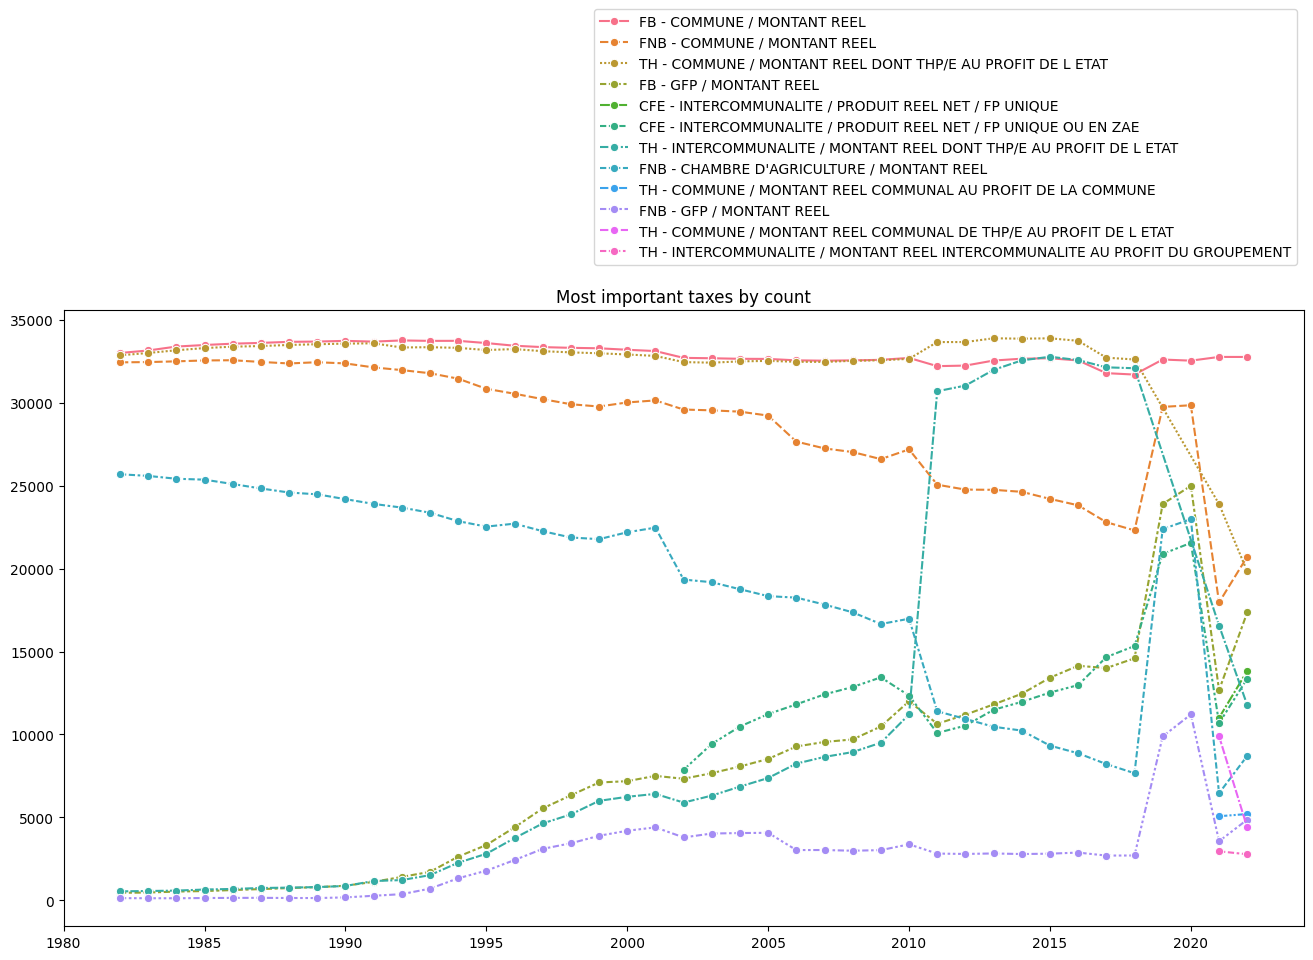

In [693]:
df_years_plt = df_years[df_years[2022] > 2000].sort_values(2022, ascending=False).head(15).T
df_years_plt
plt.figure(figsize=(16,8))
g = sns.lineplot(df_years_plt, marker='o')
g.legend(bbox_to_anchor=(1,1.5), fontsize=10)
g.set_title("Most important taxes by count")

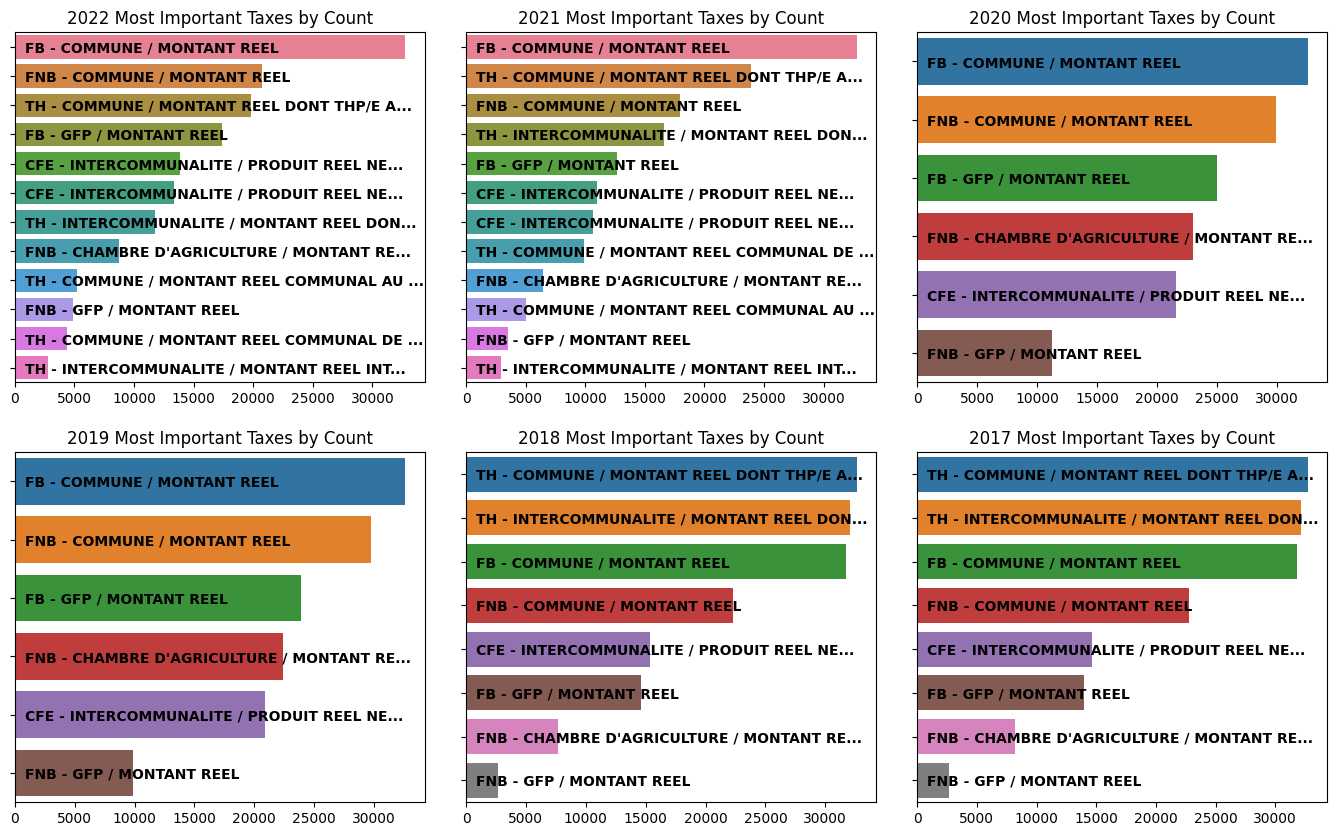

In [694]:
fig = plt.figure(figsize=(7,10))
gs = gridspec.GridSpec(2,3, right=2, hspace=0.2, wspace=0.1)

for idx, year in enumerate([2022, 2021, 2020, 2019, 2018, 2017]):
    ax = fig.add_subplot(gs[ 0 if idx < 3 else 1, idx % 3 ])
    j = sns.barplot(df_years_plt.loc[[year]].sort_values(year, axis=1, ascending=False).loc[:, (df_years_plt.loc[[year]] > 2000).any(axis=0)], orient="h", ax=ax)
    j.set(title="{} Most Important Taxes by Count".format(year))
    j.set_yticklabels([  (x.get_text() if (len(x.get_text()) < 40) else x.get_text()[:40] + "...") for x in j.get_yticklabels()], ha="left", fontdict={'weight': 'bold'})
    trans = mtrans.Affine2D().translate(20, 0)
    for t in j.get_yticklabels():
        t.set_transform(t.get_transform()+trans)

#### Top Taxes by Income

Text(0.5, 1.0, 'Taxes by total income')

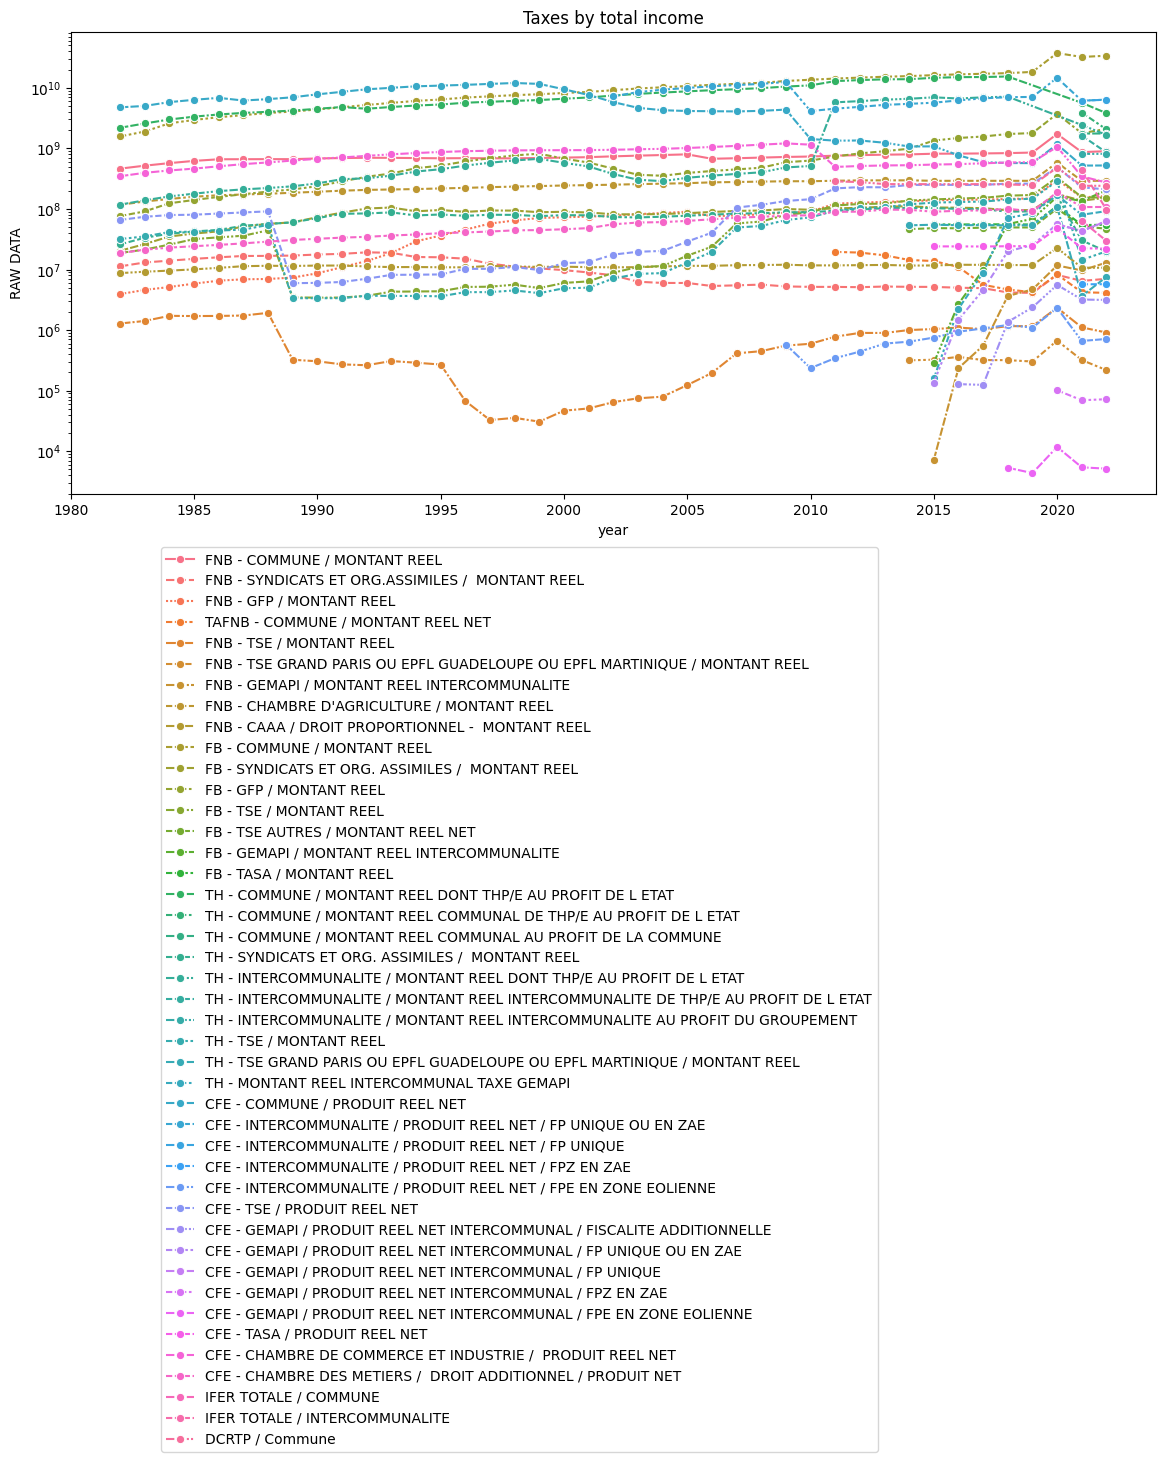

In [799]:
df_prof = df_filtered.rename(columns = d)
df_prof
df_prof = df_prof.drop(columns=["mun_name", "dep_name", "reg_name", "NOM DE L EPT", "code INSEE", "CODE REGION", "pop"]).groupby("year").sum().reset_index()
df_prof.loc[df_prof['year'] < 2002] /= 6.557957
df_prof.loc[df_prof['year'] < 2002, "year"] *= 6.557957
plt.figure(figsize=(14,6))
df_prof = df_prof.set_index("year")
df_prof.replace(0, np.nan, inplace=True)
g = sns.lineplot(df_prof.drop(columns=["NUMERO SIREN DE L EPT", "TOTAL_TAX_SUM"]), marker='o', linestyle='')
g.set(yscale="log", ylabel="RAW DATA")
# g.set(yscale="log", ylabel="RAW DATA")
g.legend(bbox_to_anchor=(0.75,-0.1), fontsize=10)
g.set_title("Taxes by total income")

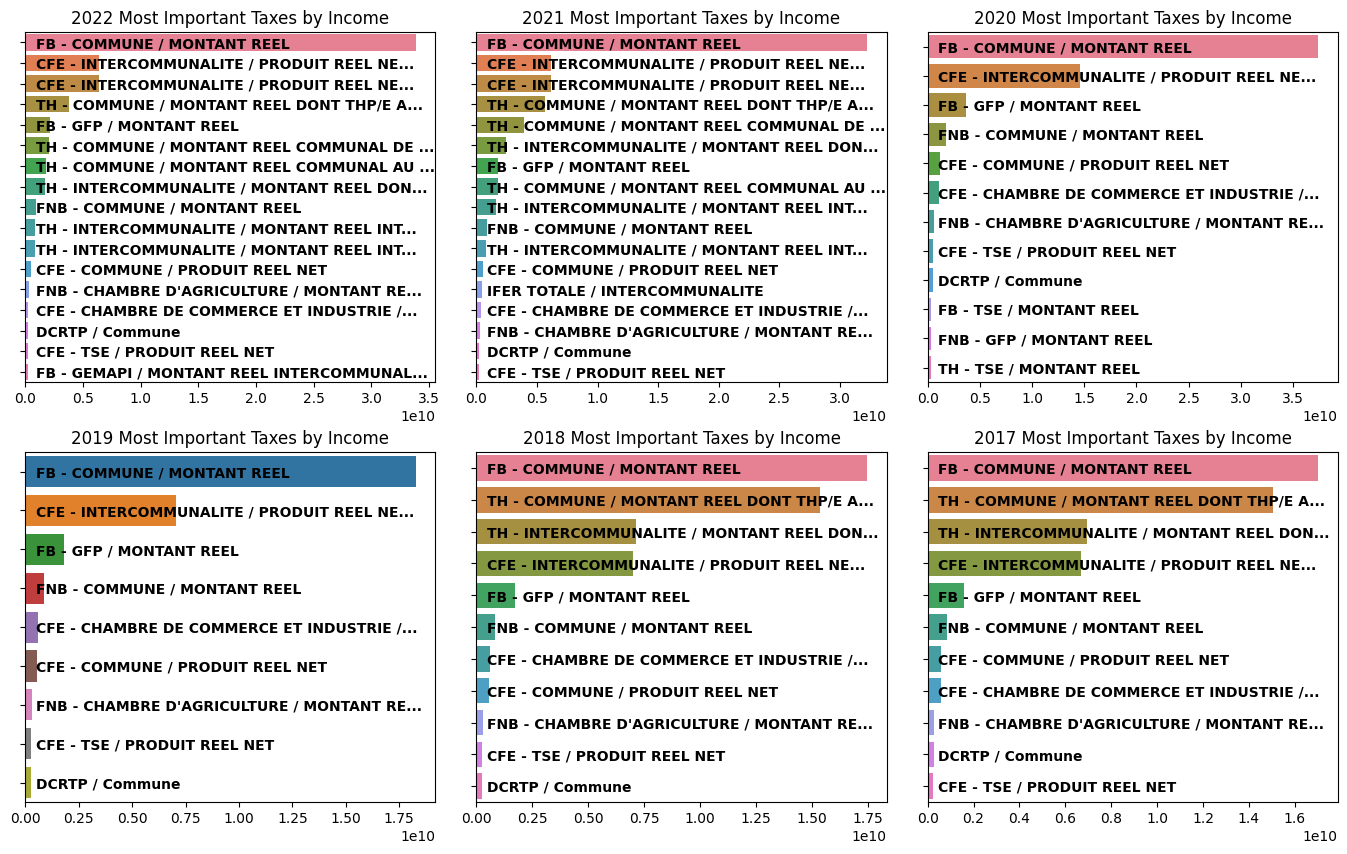

In [802]:
fig = plt.figure(figsize=(7,10))
gs = gridspec.GridSpec(2,3, right=2, hspace=0.2, wspace=0.1)

for idx, year in enumerate([2022, 2021, 2020, 2019, 2018, 2017]):
    ax = fig.add_subplot(gs[ 0 if idx < 3 else 1, idx % 3 ])
    j = sns.barplot(df_prof.loc[[year]].drop(columns=["NUMERO SIREN DE L EPT", "TOTAL_TAX_SUM"]).sort_values(year, axis=1, ascending=False).loc[:, (df_prof.loc[[year]] > 200000000).any(axis=0)], orient="h", ax=ax)
    j.set(title="{} Most Important Taxes by Income".format(year))
    j.set_yticklabels([  (x.get_text() if (len(x.get_text()) < 40) else x.get_text()[:40] + "...") for x in j.get_yticklabels()], ha="left", fontdict={'weight': 'bold'})
    trans = mtrans.Affine2D().translate(20, 0)
    for t in j.get_yticklabels():
        t.set_transform(t.get_transform()+trans)

In [697]:
df_prof.to_csv("Most_Important_Taxes_By_Total_Income.csv")

#### Final Observations
- Top Taxes by Count
    - There is a big jump in the TH tax, which we will discuss in further detail in the Professional Tax section
    - 2019 saw many taxes jump up significantly in popularity
    - Consistently, the most grossing tax over time has been **FB - MUNICIPALITY / ACTUAL AMOUNT**
- Top Taxes by Income
    - 2014 and 2015 saw the introduction of a lot of different taxes that didn't exist beforehand
    - In 2020 there was a large increase of tax income across the board

### Professional Tax

A good place to start in identifying the impact of this tax change is to see where certain taxes shifted on the popularity scale during 2009 to 2011. We can identify key taxes in this area and see how they changed. We need to to look at general trends in the data instead of just one tax to identify any other changes that may have occured during this time.

**Goals:**
- Identify trends and big changes between 2010 and 2011
- Identify why those changes exist and what caused them
- Validate these changes with our understanding of the TP tax

**Methods**: \
We will look at the following:
- Top Taxes by Count
    - Identify which taxes changed the most between 2010 and 2011
    - *By Count* Refers to how often each tax appeared in the top 5 taxes of a region
- Top Taxes by Income
    - After identifying the four taxes that changed the most (by count), cross-validate this information with income data for each tax
    - For brevity, we only include taxes > $1b gross income.
- Top Communes by Income
    - See if changes occured that are visible in the income from each commune
- DCRTP Tax
    - Should provide insight about the TP change over time

#### Top Taxes by Count (2008 - 2012)

Text(0.5, 1.0, 'Most important taxes by count 2008-2012')

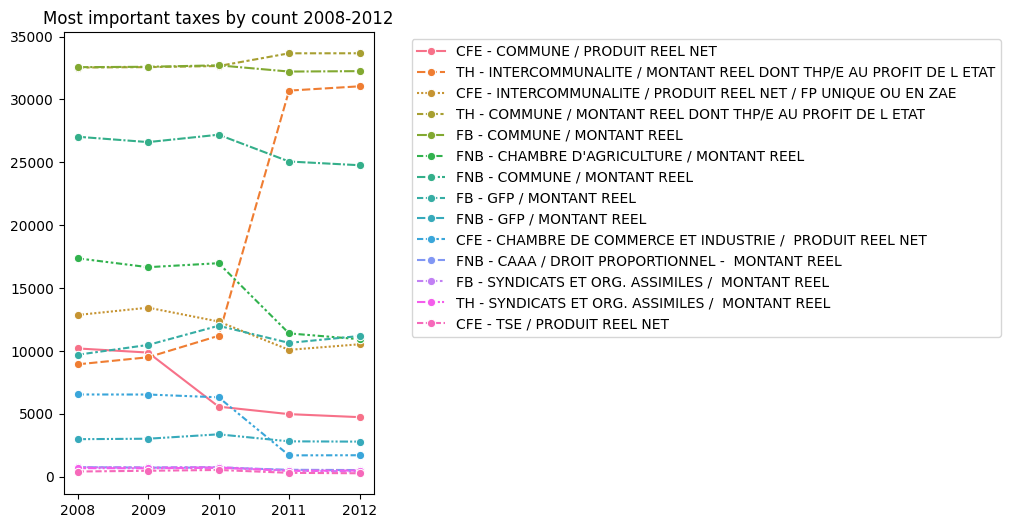

In [698]:
df_years_plt = df_years[df_years[2010] > 500].T.loc[[2008, 2009, 2010, 2011, 2012]]
plt.figure(figsize=(4,6))
g = sns.lineplot(df_years_plt, marker='o')
g.legend(bbox_to_anchor=(1.1,1), fontsize=10)
g.set_title("Most important taxes by count 2008-2012")

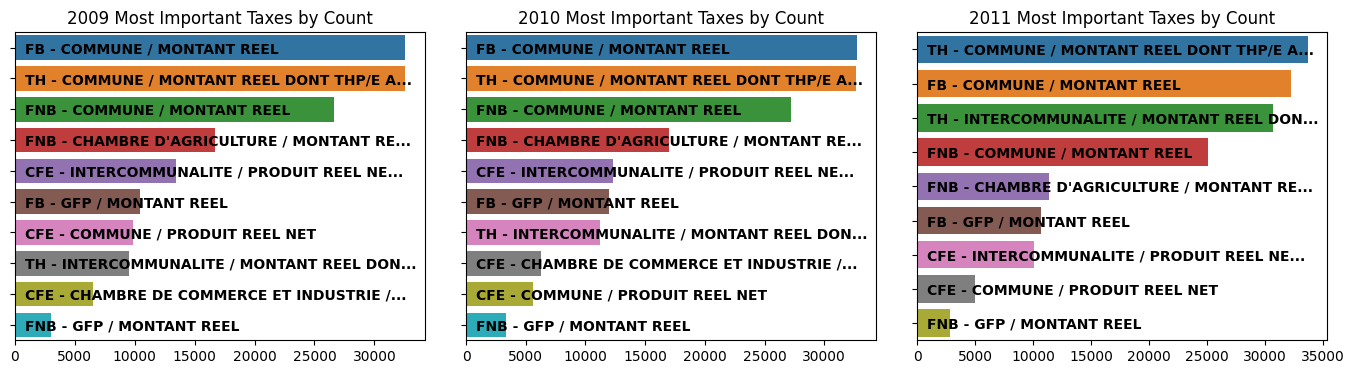

In [699]:
fig = plt.figure(figsize=(7,4))
gs = gridspec.GridSpec(1,3, right=2, hspace=0.2, wspace=0.1)

for idx, year in enumerate([2009, 2010, 2011]):
    ax = fig.add_subplot(gs[ 0, idx ])
    j = sns.barplot(df_years_plt.loc[[year]].sort_values(year, axis=1, ascending=False).loc[:, (df_years_plt.loc[[year]] > 2000).any(axis=0)], orient="h", ax=ax)
    j.set(title="{} Most Important Taxes by Count".format(year))
    j.set_yticklabels([  (x.get_text() if (len(x.get_text()) < 40) else x.get_text()[:40] + "...") for x in j.get_yticklabels()], ha="left", fontdict={'weight': 'bold'})
    trans = mtrans.Affine2D().translate(20, 0)
    for t in j.get_yticklabels():
        t.set_transform(t.get_transform()+trans)

The tax that rose the most:

- **TH - INTERCOMMUNALITY / ACTUAL AMOUNT OF WHICH THP/E FOR THE BENEFIT OF THE STATE**

The taxes that fell the most:
- **CFE - CHAMBER OF COMMERCE AND INDUSTRY / REAL NET PRODUCT**
- **CFE - COMMON / REAL NET PRODUCT**
- **CFE - INTERCOMMUNALITY / REAL NET PRODUCT / SINGLE FP OR IN ZAE**
- **FB - CHAMBRE D'AGRICULTURE / MONTANT REAL**

#### Top Communes by Income (2008 - 2012)

[None, Text(0, 0.5, 'RAW DATA')]

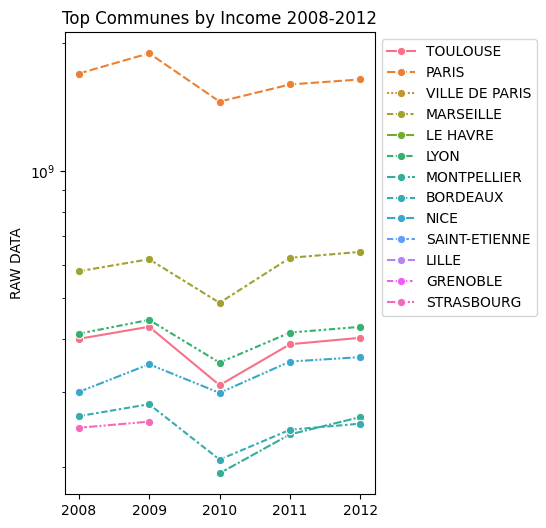

In [700]:
plt.figure(figsize=(4,6))
g = sns.lineplot(df_non_interp.loc[[2008,2009,2010,2011,2012]], marker='o', linestyle='')
g.legend(bbox_to_anchor=(1,1), fontsize=10)
g.set_title("Top Communes by Income 2008-2012")
g.set(yscale="log", ylabel="RAW DATA")

**Observations**:
- Large decrease in total income produced between 2009 and 2010
- Largeer-than-normal increase in income between 2010 and 2011 

#### Top Taxes by Income

In [701]:
df_prof = df_filtered.drop(columns=["mun_name", "dep_name", "reg_name", " NAME OF THE EPT", " INSEE code", " REGION CODE", "pop", "TOTAL_TAX_SUM", " EPT SIREN NUMBER"]).groupby("year").sum().reset_index()
df_prof.loc[df_prof['year'] < 2002] /= 6.557957
df_prof.loc[df_prof['year'] < 2002, "year"] *= 6.557957
df_prof = df_prof.set_index("year")
df_prof.replace(0, np.nan, inplace=True)

In [702]:
# plt.figure(figsize=(14,6))
# g = sns.lineplot(df_prof.T[df_prof.T[2010] > 99999].T, marker='o', linestyle='')
# g.set(yscale="log", ylabel="RAW DATA")
# g.legend(bbox_to_anchor=(0.75,-0.1), fontsize=10)
# g.set_title("Taxes by total income")
# plt.axvline(x=2009, color="k")
# plt.axvline(x=2012, color="k")

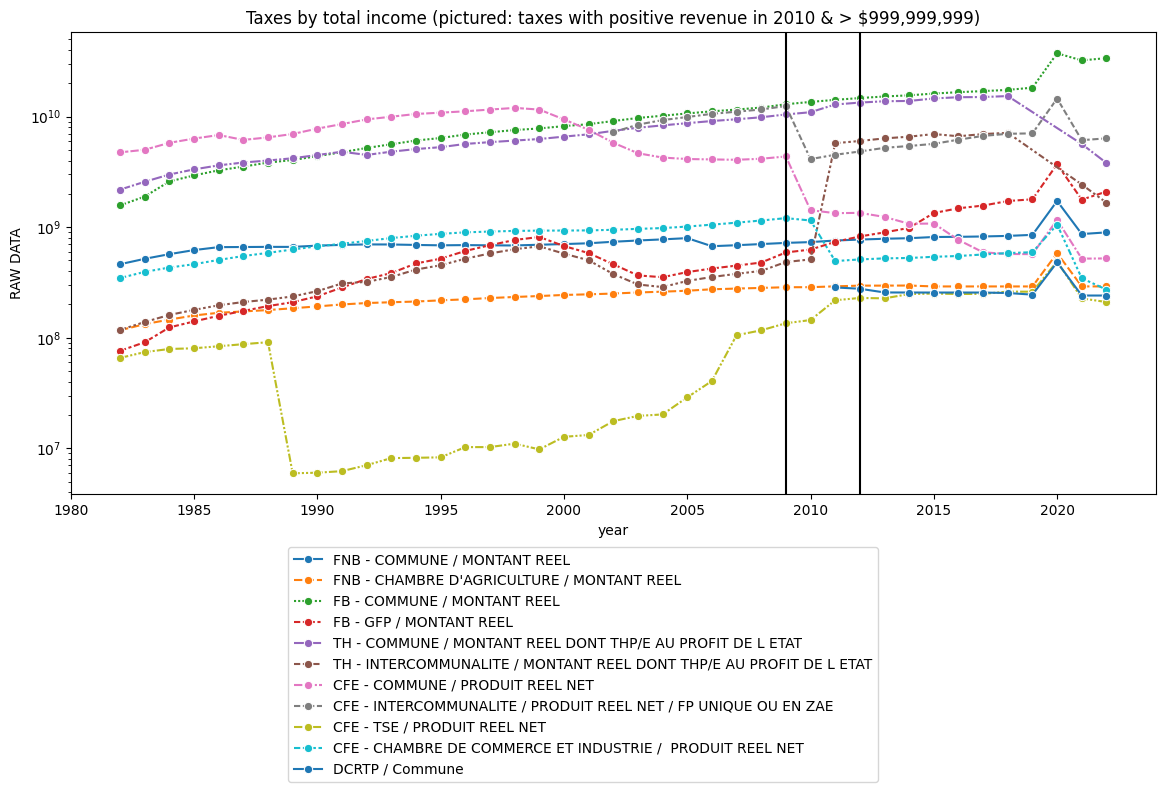

In [854]:
plt.figure(figsize=(14,6))
df_prof = df_prof.rename(columns = d)
g = sns.lineplot(df_prof.T[df_prof.T[2010] > 99999999].T.drop(columns=["TOTAL_TAX_SUM"]), marker='o', linestyle='')
g = sns.lineplot(df_prof[["DCRTP / Commune"]], marker='o', linestyle='')
g.set(yscale="log", ylabel="RAW DATA")
g.legend(bbox_to_anchor=(0.75,-0.1), fontsize=10)
g.set_title("Taxes by total income (pictured: taxes with positive revenue in 2010 & > $999,999,999)")
plt.axvline(x=2009, color="k")
plt.axvline(x=2012, color="k")

In [848]:
df_prof.head()

NUMERO SIREN DE L EPT  FNB - COMMUNE / MONTANT REEL  \
year                                                           
1982.00                    NaN                  462682487.24   
1983.00                    NaN                  517699818.10   
1984.00                    NaN                  570522490.92   
1985.00                    NaN                  620936648.56   
1986.00                    NaN                  660262538.01   

         FNB - SYNDICATS ET ORG.ASSIMILES /  MONTANT REEL  \
year                                                        
1982.00                                       11272392.91   
1983.00                                       13061879.79   
1984.00                                       14001653.72   
1985.00                                       14983100.07   
1986.00                                       15898151.06   

         FNB - GFP / MONTANT REEL  TAFNB - COMMUNE / MONTANT REEL NET  \
year                                                                    
1982.00                3929890.06                                 NaN   
1983.00                4596863.32                                 NaN   
1984.00                5144959.78                                 NaN   
1985.00                5846023.24                                 NaN   
1986.00                6537440.39                                 NaN   

         FNB - TSE / MONTANT REEL  \
year                                
1982.00                1283415.25   
1983.00                1413820.49   
1984.00                1717856.64   
1985.00                1703821.78   
1986.00                1711853.86   

         FNB - TSE GRAND PARIS OU EPFL GUADELOUPE OU EPFL MARTINIQUE / MONTANT REEL  \
year                                                                                  
1982.00                                                NaN                            
1983.00                                                NaN                            
1984.00                                                NaN                            
1985.00                                                NaN                            
1986.00                                                NaN                            

         FNB - GEMAPI / MONTANT REEL INTERCOMMUNALITE  \
year                                                    
1982.00                                           NaN   
1983.00                                           NaN   
1984.00                                           NaN   
1985.00                                           NaN   
1986.00                                           NaN   

         FNB - CHAMBRE D'AGRICULTURE / MONTANT REEL  \
year                                                  
1982.00                                116953313.97   
1983.00                                132796728.16   
1984.00                                146064486.09   
1985.00                                159026114.54   
1986.00                                168236964.50   

         FNB - CAAA / DROIT PROPORTIONNEL -  MONTANT REEL  ...  \
year                                                       ...   
1982.00                                        8714057.90  ...   
1983.00                                        9192808.22  ...   
1984.00                                        9580657.67  ...   
1985.00                                       10052790.83  ...   
1986.00                                       10641662.03  ...   

         CFE - GEMAPI / PRODUIT REEL NET INTERCOMMUNAL / FP UNIQUE  \
year                                                                 
1982.00                                                NaN           
1983.00                                                NaN           
1984.00                                                NaN           
1985.00                                                NaN           
1986.00                                                NaN           

         C

<Axes: xlabel='year'>

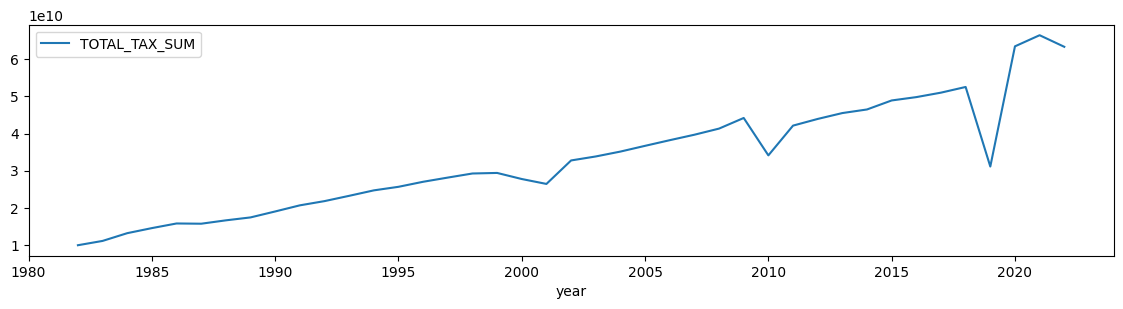

In [853]:
plt.figure(figsize=(14,3))
df_prof_plt = df_prof.copy().reset_index()
df_prof_plt.loc[df_prof_plt['year'] < 2002, "TOTAL_TAX_SUM"] *= 6.557957
sns.lineplot(df_prof_plt[["year", "TOTAL_TAX_SUM"]].set_index("year"))

**Observations**:
- The dip in revenue from 2010 to 2011 doesn't seem to be affected by the TP tax at all
- We do not have data for the TP tax before 2010, so we can't see the change over that period of time
- **TH - INTERCOMMUNALITY / ACTUAL AMOUNT OF WHICH THP/E FOR THE BENEFIT OF THE STATE** sees the biggest, most obvious change after the fact

**Plotting the TP Tax**

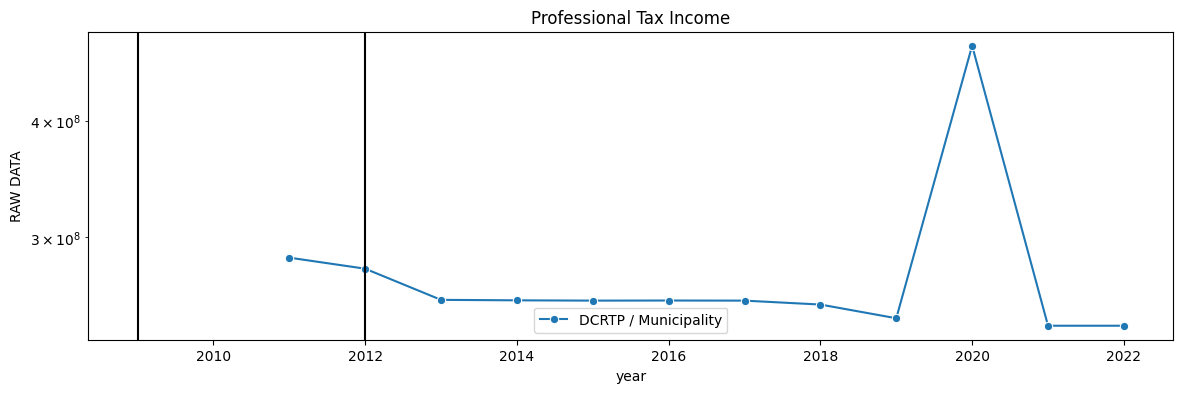

In [704]:
plt.figure(figsize=(14,4))
g = sns.lineplot(df_prof[["DCRTP / Municipality"]], marker='o', linestyle='')
g.set(yscale="log", ylabel="RAW DATA")
# g.legend(bbox_to_anchor=(0.75,-0.1), fontsize=10)
g.set_title("Professional Tax Income")
plt.axvline(x=2009, color="k")
plt.axvline(x=2012, color="k")

**Observations**:
- The TP tax per-commune appears *after* 2011 and not before, like we might expect

#### Final Observations
- **Top Taxes by Count**
    - The tax that rose the most:
        - *TH - INTERCOMMUNALITY / ACTUAL AMOUNT OF WHICH THP/E FOR THE BENEFIT OF THE STATE*
    - The taxes that fell the most:
        - *CFE - CHAMBER OF COMMERCE AND INDUSTRY / REAL NET PRODUCT*
        - *CFE - COMMON / REAL NET PRODUCT*
        - *CFE - INTERCOMMUNALITY / REAL NET PRODUCT / SINGLE FP OR IN ZAE*
        - *FB - CHAMBRE D'AGRICULTURE / MONTANT REAL*
- **Top Taxes by Income**
    - The dip in revenue from 2010 to 2011 doesn't seem to be affected by the TP tax at all
    - We do not have data for the TP tax before 2010, so we can't see the change over that period of time
    - *TH - INTERCOMMUNALITY / ACTUAL AMOUNT OF WHICH THP/E FOR THE BENEFIT OF THE STATE* sees the biggest, most obvious change after the fact
- **Top Communes by Income**
    - Large decrease in total income produced between 2009 and 2010
    - Largeer-than-normal increase in income between 2010 and 2011 
- **DCRTP Tax**
    - The TP tax per-commune appears *after* 2011 and not before, like we might expect

**Conclusion**: \
Without speculation, we can clearly see that the TH and CFE taxes were affected the most. CFE Taxes decreased collectively, one FB tax decreased, and the TH tax increased. We do not have data about the TP tax before 2010 explicitly, only after. Even though the tax was abolished, we can see that the DCRTP tax exists after the fact, though it may be that this tax no longer represents the TP tax but something else. It's reasonable to suggest that the TP tax was in fact removed, but the specific categorization of it was split up / redesigned into or from other tax categories.

It's clear that the dip in income was caused by the CFE and FB taxes decreasing; whether the TP tax is/was included in this category before 2011 is unknown.

**Speculation**: \
https://fr.wikipedia.org/wiki/Taxe_professionnelle_en_France Describes the use of the TP in France and its general changeover. It's possible that the TP tax was not represented in its own form until after the reform, and prior to 2011 was rolled into some other business tax category. **CFE** is a likely candidate: (https://www.lbsinfrance.com/cfe-tax-all-the-questions-answered) This article describes the CFE tax as **a small tax paid by businesses to the local authorities and collected by the tax office.** It's reasonable to suspect that the TP tax was rolled into this larger category before 2011 and then split up after the fact and controlled in this dataset directly as its own, explicit tax.

**More information on the TH Tax**

Between 2010 and 2011, which municipalities were affected by the increase of the TH tax the most?

In [705]:
df_grow = df_filtered[["mun_name", "year", "TH - INTERCOMMUNALITY / ACTUAL AMOUNT OF WHICH THP/E FOR THE BENEFIT OF THE STATE"]].drop_duplicates()
df_grow_gb = df_grow.groupby(["mun_name", "year"]).sum().reset_index()
df_grow_gb
df_grow_2010_2011 = df_grow_gb[df_grow_gb["year"].isin([2010, 2011])].groupby("mun_name").apply(lambda x: x.iloc[[0, -1]]).reset_index(drop=True)
df_grow_2010_2011["yr_growth"] = 0.0
df_grow_2010_2011
for i in range(1, df_grow_2010_2011.shape[0], 2):
    df_grow_2010_2011["yr_growth"].iloc[i] = (df_grow_2010_2011["TH - INTERCOMMUNALITY / ACTUAL AMOUNT OF WHICH THP/E FOR THE BENEFIT OF THE STATE"].iloc[i] - df_grow_2010_2011["TH - INTERCOMMUNALITY / ACTUAL AMOUNT OF WHICH THP/E FOR THE BENEFIT OF THE STATE"].iloc[i-1]) / df_grow_2010_2011["TH - INTERCOMMUNALITY / ACTUAL AMOUNT OF WHICH THP/E FOR THE BENEFIT OF THE STATE"].iloc[i-1] * 100


In [706]:
x = df_grow_2010_2011[ (df_grow_2010_2011["yr_growth"] < 99999999) & (df_grow_2010_2011["yr_growth"] > -100)].sort_values("yr_growth", ascending=False)
x.to_csv("Total_Growth_of_Communes_TH_INTERCOMMUNALITY_Tax.csv")
x

mun_name  year  \
681                   ALLEMOND  2011   
7029               BOIS-D'ARCY  2011   
34709           LIVET-ET-GAVET  2011   
5295                BELLEGARDE  2011   
10837                  CASTRES  2011   
...                        ...   ...   
24577               GUILLAUMES  2011   
12757  CHATEAUNEUF-D'ENTRAUNES  2011   
18949                ENTRAUNES  2011   
17013                   DALUIS  2011   
57815              SAINTE-LUCE  2011   

       TH - INTERCOMMUNALITY / ACTUAL AMOUNT OF WHICH THP/E FOR THE BENEFIT OF THE STATE  \
681                                             12969.00                                   
7029                                          1488539.00                                   
34709                                            9348.00                                   
5295                                           796343.00                                   
10837                                         4795396.00                                   
...                                                  ...                                   
24577                                           43711.00                                   
12757                                            1299.00                                   
18949                                            5656.00                                   
17013                                            2780.00                                   
57815                                            1971.00                                   

       yr_growth  
681   1296800.00  
7029   740466.67  
34709  311500.00  
5295   306185.77  
10837  277411.34  
...          ...  
24577     -33.91  
12757     -34.19  
18949     -34.91  
17013     -37.25  
57815     -97.38  

[54511 rows x 4 columns]

Let's select a few of the top and see what the deal is with high growth...

In [707]:
df_grow_2010_2011[ (df_grow_2010_2011["yr_growth"] < 99999999) & (df_grow_2010_2011["yr_growth"] > -100)][df_grow_2010_2011["mun_name"].isin(["ALLEMOND", "BOIS-D'ARCY", "LIVET-ET-GAVET"])].sort_values(["mun_name", "year"], ascending=False)

mun_name  year  \
34709  LIVET-ET-GAVET  2011   
34708  LIVET-ET-GAVET  2010   
7029      BOIS-D'ARCY  2011   
7028      BOIS-D'ARCY  2010   
681          ALLEMOND  2011   
680          ALLEMOND  2010   

       TH - INTERCOMMUNALITY / ACTUAL AMOUNT OF WHICH THP/E FOR THE BENEFIT OF THE STATE  \
34709                                            9348.00                                   
34708                                               3.00                                   
7029                                          1488539.00                                   
7028                                              201.00                                   
681                                             12969.00                                   
680                                                 1.00                                   

       yr_growth  
34709  311500.00  
34708       0.00  
7029   740466.67  
7028        0.00  
681   1296800.00  
680         0.00

<Axes: xlabel='yr_growth', ylabel='mun_name'>

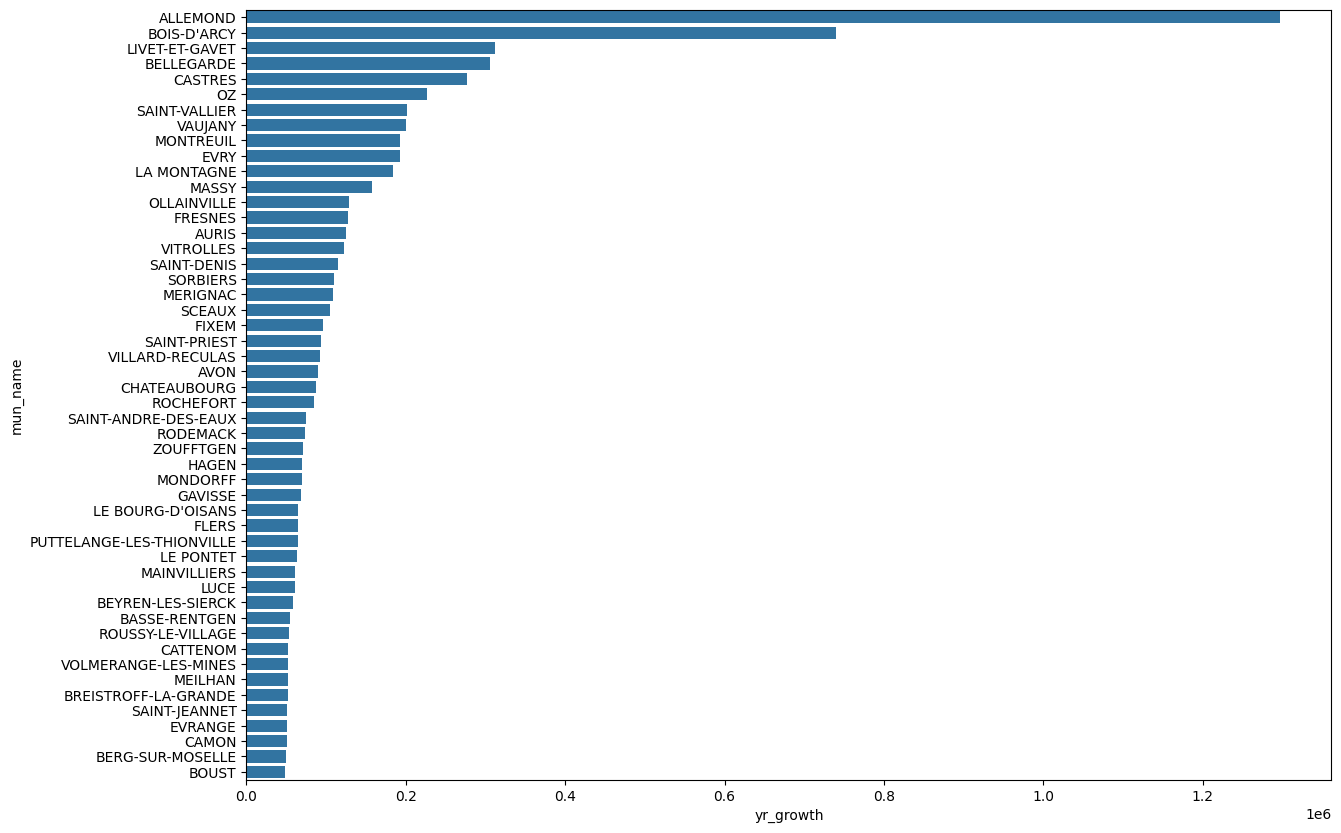

In [708]:
plt.figure(figsize=(14,10))
sns.barplot(x.head(50), x="yr_growth", y="mun_name")

### Prediction Model

There are a few things we can create a model to predict:

**Total Income Regression** \
We identified earlier that there is a very clear relationship between population and total income. We also assume that a clear linear relationship exists with every tax and a total of those taxes, since it's just addition. If we did this, we could use either just population, or population and all of the applicable taxes that predict total income for a commune.

**Specific Tax Regression** \
Like total income, we could also do it with specific taxes and see how they may change over time.

**Classification** \
There are a good many variables in this dataset that fall into a classic classification problem. For example Variable 1091 is a yes/no variable that describes if "The municipality is partially or totally within a regional aid area", or Variable 1107: "The municipality has instituted an increase in council tax on second homes". Ultimately these could be used to answer a question like, "Does X commune fall into the high tax bracket?" or "Is X commune part of Y region?". The problem with both of these, and any derivitives, are that we already have this information and need not predict such features; "tax brackets" could be answered with a simpler algorithm (or a calculator) and we already know what communes are in each region.

To keep things simple, we'll go with a Linear Regression, since our data is pretty linear anyway and has a high correlation, and keep it to predicting the total tax sum for regions. We might consider using a different type of regression model if our data had a lower correlation (say 0.6 or lower), but a 0.97 correlation suggests the data is very linearly related.

In [709]:
df_corr = df_filtered[["mun_name", "pop", "TOTAL_TAX_SUM"]].set_index("mun_name")
df_corr = df_corr[df_corr["pop"] > 10]
df_corr = df_corr[df_corr["TOTAL_TAX_SUM"] > 10].drop_duplicates()
df_corr.corr()

pop  TOTAL_TAX_SUM
pop           1.00           0.97
TOTAL_TAX_SUM 0.97           1.00

<Axes: xlabel='TOTAL_TAX_SUM', ylabel='pop'>

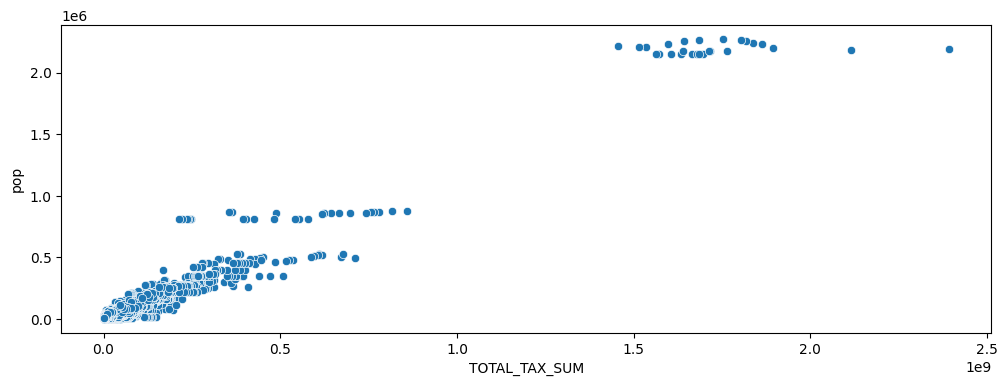

In [710]:
plt.figure(figsize=(12,4))
sns.scatterplot(df_corr, y="pop", x="TOTAL_TAX_SUM")

**Topic: Feature Importance** \
We can plot the predictions in the model to indentify how important each feature was to our prediction. Some may be important, others not so helpful, and others still even harmful to our model. A negative score means the variable hurt the model and a positive score means it helped the model.

**Linear model with just population as a feature** \
The correlation we just identified has a pretty strong relationship with just population as a predicting feature - let's see what happens if we just use that.

In [858]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 

X = df_corr[["pop"]]
y = df_corr[["TOTAL_TAX_SUM"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

model = LinearRegression() 
model.fit(X_train,y_train)
predictions = model.predict(X_test) 

print('mean_squared_error : ', mean_squared_error(y_test, predictions)) 
print('mean_absolute_error : ', mean_absolute_error(y_test, predictions))

model.score(X_test, y_test)

mean_squared_error :  7700073892159.787
mean_absolute_error :  498747.44542032917


0.9482892805738853

Text(0.5, 1.0, 'Linear model with population only: 94.82%')

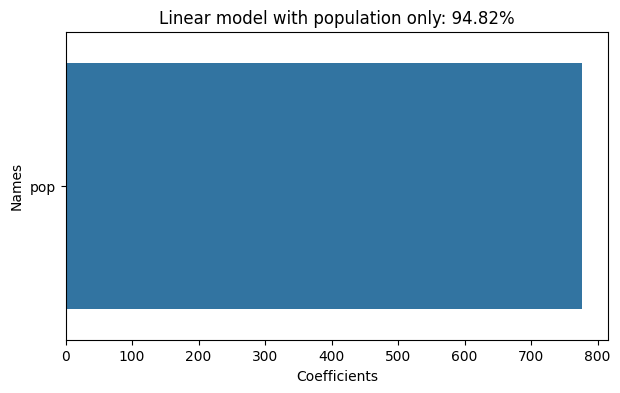

In [857]:
coefs = pd.DataFrame(
    model.coef_.reshape((1,1)), columns=["Coefficients"], index=X_train.columns
).reset_index(names="Names")

fig = plt.figure(figsize=(7,4))
g = sns.barplot(coefs.sort_values("Coefficients")[(coefs["Coefficients"] > 10) | (coefs["Coefficients"] < -10)], x="Coefficients", y="Names")
g.set_title("Linear model with population only: 94.82%")

Yes... very useful graph

**95.16% Accuracy**

**Linear Model with all taxes as predictive features** \
Now, with all of the taxes instead of just population. Does not include population as a predicting feature

In [859]:
# df_filtered.drop(columns=["mun_name", " INSEE code", "year", " REGION CODE", "dep_name", "reg_name", "pop", " EPT SIREN NUMBER", " NAME OF THE EPT", "TOTAL_TAX_SUM"]).head()

In [862]:
X = df_filtered.drop(columns=["mun_name", " INSEE code", "year", " REGION CODE", "dep_name", "reg_name", "pop", " EPT SIREN NUMBER", " NAME OF THE EPT", "TOTAL_TAX_SUM"])
y = df_filtered[["TOTAL_TAX_SUM"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

model = LinearRegression() 
model.fit(X_train,y_train)
predictions = model.predict(X_test) 

print('mean_squared_error : ', mean_squared_error(y_test, predictions)) 
print('mean_absolute_error : ', mean_absolute_error(y_test, predictions))

model.score(X_test, y_test)

mean_squared_error :  17049752039906.674
mean_absolute_error :  409451.0226533011


0.8236500503800346

**82.36% Accuracy**

Text(0.5, 1.0, 'Linear Model with all taxes as predictive features: 82.36%')

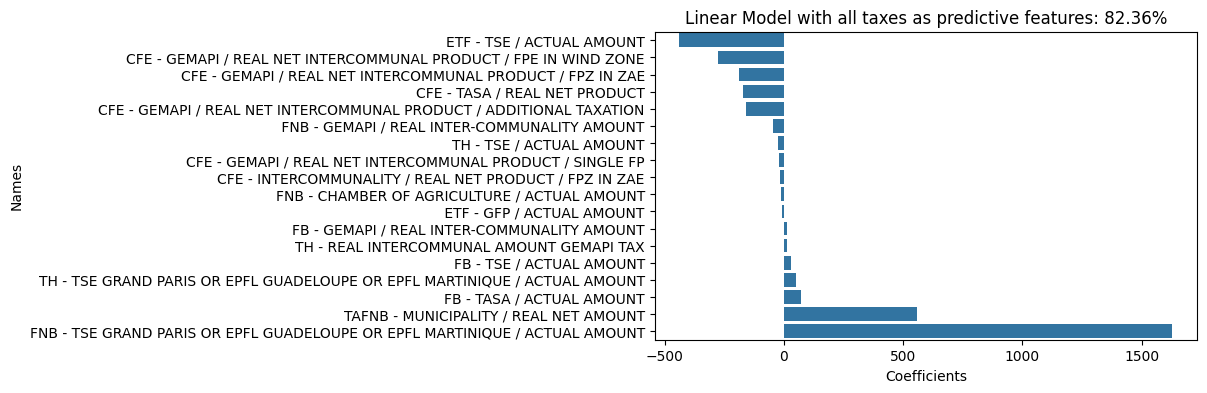

In [863]:
coefs = pd.DataFrame(
    model.coef_.reshape((43,1)), columns=["Coefficients"], index=X_train.columns
).reset_index(names="Names")

fig = plt.figure(figsize=(7,4))
g = sns.barplot(coefs.sort_values("Coefficients")[(coefs["Coefficients"] > 10) | (coefs["Coefficients"] < -10)], x="Coefficients", y="Names")
g.set_title("Linear Model with all taxes as predictive features: 82.36%")

**Linear Model with all taxes as predictive features AND population** \
Now, with all of the taxes instead of just population

In [867]:
X = df_filtered.drop(columns=["mun_name", " INSEE code", "year", " REGION CODE", "dep_name", "reg_name", " EPT SIREN NUMBER", " NAME OF THE EPT", "TOTAL_TAX_SUM"])
y = df_filtered[["TOTAL_TAX_SUM"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

model = LinearRegression() 
model.fit(X_train,y_train)
predictions = model.predict(X_test) 

print('mean_squared_error : ', mean_squared_error(y_test, predictions)) 
print('mean_absolute_error : ', mean_absolute_error(y_test, predictions))

model.score(X_test, y_test)

mean_squared_error :  5192814777114.136
mean_absolute_error :  316787.09201730957


0.9462893875414448

**94.62% Accuracy**

Text(0.5, 1.0, 'Linear Model with all taxes as predictive features AND population: 94.62%')

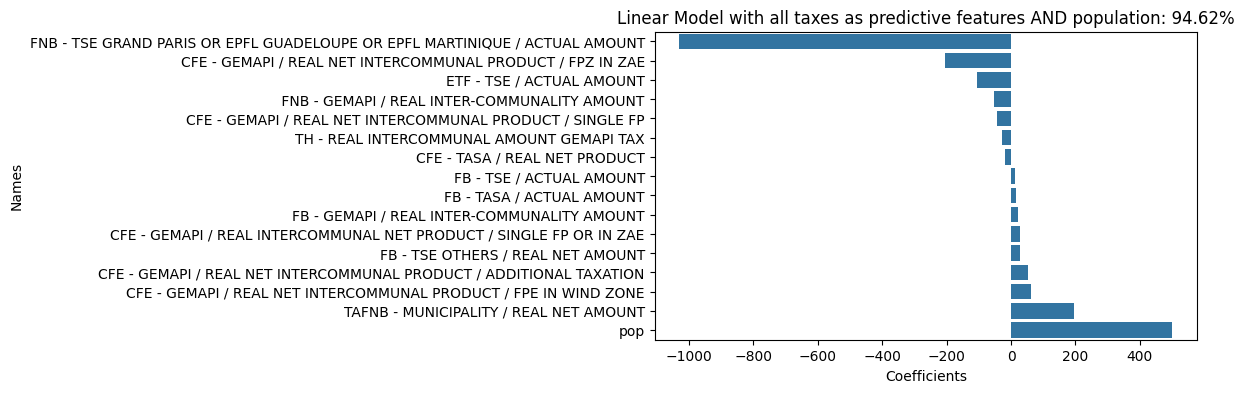

In [869]:
coefs = pd.DataFrame(
    model.coef_.reshape((44,1)), columns=["Coefficients"], index=X_train.columns
).reset_index(names="Names")

fig = plt.figure(figsize=(7,4))
g = sns.barplot(coefs.sort_values("Coefficients")[(coefs["Coefficients"] > 10) | (coefs["Coefficients"] < -10)], x="Coefficients", y="Names")
g.set_title("Linear Model with all taxes as predictive features AND population: 94.62%")

**Linear Model with FNB - TSE GRAND PARIS OR EPFL GUADELOUPE OR EPFL MARTINIQUE / ACTUAL AMOUNT as the only predcitor**

In [870]:
X = df_filtered[["FNB - TSE GRAND PARIS OR EPFL GUADELOUPE OR EPFL MARTINIQUE / ACTUAL AMOUNT"]]
y = df_filtered[["TOTAL_TAX_SUM"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

model = LinearRegression() 
model.fit(X_train,y_train)
predictions = model.predict(X_test) 

print('mean_squared_error : ', mean_squared_error(y_test, predictions)) 
print('mean_absolute_error : ', mean_absolute_error(y_test, predictions))

model.score(X_test, y_test)

mean_squared_error :  86300360943266.45
mean_absolute_error :  1239866.565709893


0.10737327622665083

**10.73% Accuracy**

#### Final Observations
- Linear model with just population: **95.16% Accuracy**
- Linear model with all taxes: **82.36% Accuracy**
- Linear model with both: **94.62% Accuracy**
- Linear model with the least important feature: **10.73% Accuracy**



Predict future data

In [871]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 

X = df_corr[["pop"]]
y = df_corr[["TOTAL_TAX_SUM"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

model = LinearRegression() 
model.fit(X_train,y_train)
predictions = model.predict(X_test) 

print('mean_squared_error : ', mean_squared_error(y_test, predictions)) 
print('mean_absolute_error : ', mean_absolute_error(y_test, predictions))

model.score(X_test, y_test)

mean_squared_error :  7700073892159.787
mean_absolute_error :  498747.44542032917


0.9482892805738853

<Axes: xlabel='year'>

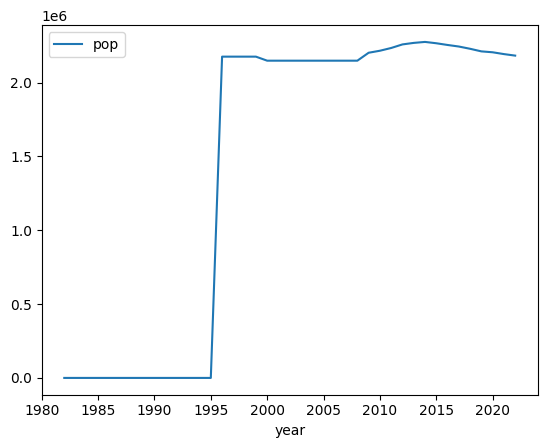

In [886]:
df_pred = pd.concat([df_filtered[df_filtered["mun_name"] == "PARIS"], df_filtered[df_filtered["mun_name"] == "VILLE DE PARIS"]]).sort_values("year", ascending=False)[["year", "pop"]]
df_pred.set_index("year")[["pop"]].plot()

### API Usage

In [ ]:
# Define the S3 URI and local path
# s3_uri = 's3://oceandatachallengebucket/public/francetax.parquet'
# local_path = 'C:/Users/ppc/Notebooks/French Finance/datasharing/notebooks/francetax.parquet'

# # Download the dataset
# client.download_dataset(s3_uri, local_path)

#https://github.com/ChristianCasazza/datasharing

In [ ]:
# View all tables and views in duckdb
# tables = client.list_tables()
# print(tables)

In [ ]:
# Query a view or table and create a duckdb table
# query = "SELECT COUNT(*) FROM francetax;"
# new_table_name = "francerowcount"

# # Create a new table from the query
# client.query(query, new_table_name)

In [ ]:
#Export a duckdb table as csv or parquet
# table_names = ["francerowcount"]
# output_dir = "C:/Users/ppc/Notebooks/French Finance/datasharing/notebooks"

# # Export the tables to CSV format
# client.export_tables(table_names, output_dir, "csv")#parquet for parquet export